## Introduction

First I load and preprocess the data for modeling. In part 1, I build neural networks with all the features (69) in the data. In part 2, I build a linear regression model with a grid search to get the best one, and use the coefficients from this model for future selection. I build neural network models with 10 less features (59). The features I drop are the ones with the coefficients closest to 0. In Part 3, I build neural network models with the top 30 features based on their coefficients. In Part 4, I reduce the feature number to top 15. In Part 5, I use PCA for dimensionality reduction rather than dropping features from the data, and then build neural networks. In Part 6, I do two gridsearches for a best linear regression. The first one is on the PCA (0.9) data. For the second one, I use VIF to prevent multicolinearity in the model. Neither grid search gives a model that is better than the best neural network (model10) in terms of MAE and r2. I end the notebook by pickling this model.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from sklearn.metrics import r2_score

Let's load the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/merged_data.csv', index_col=0)
df.shape

(19975, 76)

In [ ]:
pd.set_option('display.max_columns', None) # enable scrolling and seeing all the columns

In [ ]:
df.set_index('track_id', inplace=True) # set the track_id column as index column
df.head()

track_lyrics  \
track_id                                                                    
0r7CVbZTWZgbTCYdfa2P31  Here's to the ones that we got\nCheers to the ...   
1z1Hg7Vb0AhHDiEmnDE79l  Summertime and I'm caught in the feeling\nGett...   
75FpbthrwQmzHlBJLuGdC7  Two kids with their hearts on fire\nWho's gonn...   
1e8PAfcKUYoKkxPhrHqw4x  I'm going under and this time I fear there’s n...   
7fvUMiyapMsRRxr07cU8Ef  L.A. on a Saturday night in the summer\nSundow...   

                                    gpt_ratings  ratings_length  \
track_id                                                          
0r7CVbZTWZgbTCYdfa2P31  9 8 9 8 7 9 7 6 5 4 5 8              23   
1z1Hg7Vb0AhHDiEmnDE79l  8 6 8 7 5 8 4 6 5 4 5 7              23   
75FpbthrwQmzHlBJLuGdC7  9 8 9 8 7 9 8 6 5 4 5 8              23   
1e8PAfcKUYoKkxPhrHqw4x  9 8 9 8 7 9 3 5 2 2 3 9              23   
7fvUMiyapMsRRxr07cU8Ef  9 8 9 8 7 9 6 4 3 3 4 7              23   

                        rating_counts  Clear  Relatable  Memorable  Engaging  \
track_id                                                                       
0r7CVbZTWZgbTCYdfa2P31             12      9          8          9         8   
1z1Hg7Vb0AhHDiEmnDE79l             12      8          6          8         7   
75FpbthrwQmzHlBJLuGdC7             12      9          8          9         8   
1e8PAfcKUYoKkxPhrHqw4x             12      9          8          9         8   
7fvUMiyapMsRRxr07cU8Ef             12      9          8          9         8   

                        Symbolic  Lyrical  Happy  Surprised  Fearful  Angry  \
track_id                                                                      
0r7CVbZTWZgbTCYdfa2P31         7        9      7          6        5      4   
1z1Hg7Vb0AhHDiEmnDE79l         5        8      4          6        5      4   
75FpbthrwQmzHlBJLuGdC7         7        9      8          6        5      4   
1e8PAfcKUYoKkxPhrHqw4x         7        9      3          5        2      2   
7fvUMiyapMsRRxr07cU8Ef         7        9      6          4        3      3   

                        Disgusted  Sad  track_popularity  danceability  \
track_id                                                                 
0r7CVbZTWZgbTCYdfa2P31          5    8                67         0.726   
1z1Hg7Vb0AhHDiEmnDE79l          5    7                70         0.675   
75FpbthrwQmzHlBJLuGdC7          5    8                60         0.718   
1e8PAfcKUYoKkxPhrHqw4x          3    9                69         0.650   
7fvUMiyapMsRRxr07cU8Ef          4    7                67         0.675   

                        loudness  mode  valence    tempo  duration_ms  \
track_id                                                                
0r7CVbZTWZgbTCYdfa2P31    -4.969     1    0.693   99.972       162600   
1z1Hg7Vb0AhHDiEmnDE79l    -3.432     0    0.613  124.008       176616   
75FpbthrwQmzHlBJLuGdC7    -3.778     1    0.277  121.956       169093   
1e8PAfcKUYoKkxPhrHqw4x    -4.672     1    0.725  123.976       189052   
7fvUMiyapMsRRxr07cU8Ef    -5.385     1    0.585  124.982       163049   

                        album_release_quarter_1  album_release_quarter_3  \
track_id                                                                   
0r7CVbZTWZgbTCYdfa2P31                        0                        0   
1z1Hg7Vb0AhHDiEmnDE79l                        0                        1   
75FpbthrwQmzHlBJLuGdC7                        0                        1   
1e8PAfcKUYoKkxPhrHqw4x                        1                        0   
7fvUMiyapMsRRxr07cU8Ef                        0                        1   

                        album_release_quarter_4  album_decade_1960  \
track_id                                                             
0r7CVbZTWZgbTCYdfa2P31                        1                  0   
1z1Hg7Vb0AhHDiEmnDE79l                        0                  0   
75FpbthrwQmzHlBJLuGdC7                        0                  0   
1e8PAfcKUYoKkxPhrHqw4x

In [ ]:
df.drop(columns=['track_lyrics', 'gpt_ratings', 'ratings_length', 'rating_counts', 'language'], inplace=True) # drop categorical columns that will not be features in the model

In [ ]:
df.head()

Clear  Relatable  Memorable  Engaging  Symbolic  \
track_id                                                                  
0r7CVbZTWZgbTCYdfa2P31      9          8          9         8         7   
1z1Hg7Vb0AhHDiEmnDE79l      8          6          8         7         5   
75FpbthrwQmzHlBJLuGdC7      9          8          9         8         7   
1e8PAfcKUYoKkxPhrHqw4x      9          8          9         8         7   
7fvUMiyapMsRRxr07cU8Ef      9          8          9         8         7   

                        Lyrical  Happy  Surprised  Fearful  Angry  Disgusted  \
track_id                                                                       
0r7CVbZTWZgbTCYdfa2P31        9      7          6        5      4          5   
1z1Hg7Vb0AhHDiEmnDE79l        8      4          6        5      4          5   
75FpbthrwQmzHlBJLuGdC7        9      8          6        5      4          5   
1e8PAfcKUYoKkxPhrHqw4x        9      3          5        2      2          3   
7fvUMiyapMsRRxr07cU8Ef        9      6          4        3      3          4   

                        Sad  track_popularity  danceability  loudness  mode  \
track_id                                                                      
0r7CVbZTWZgbTCYdfa2P31    8                67         0.726    -4.969     1   
1z1Hg7Vb0AhHDiEmnDE79l    7                70         0.675    -3.432     0   
75FpbthrwQmzHlBJLuGdC7    8                60         0.718    -3.778     1   
1e8PAfcKUYoKkxPhrHqw4x    9                69         0.650    -4.672     1   
7fvUMiyapMsRRxr07cU8Ef    7                67         0.675    -5.385     1   

                        valence    tempo  duration_ms  \
track_id                                                
0r7CVbZTWZgbTCYdfa2P31    0.693   99.972       162600   
1z1Hg7Vb0AhHDiEmnDE79l    0.613  124.008       176616   
75FpbthrwQmzHlBJLuGdC7    0.277  121.956       169093   
1e8PAfcKUYoKkxPhrHqw4x    0.725  123.976       189052   
7fvUMiyapMsRRxr07cU8Ef    0.585  124.982       163049   

                        album_release_quarter_1  album_release_quarter_3  \
track_id                                                                   
0r7CVbZTWZgbTCYdfa2P31                        0                        0   
1z1Hg7Vb0AhHDiEmnDE79l                        0                        1   
75FpbthrwQmzHlBJLuGdC7                        0                        1   
1e8PAfcKUYoKkxPhrHqw4x                        1                        0   
7fvUMiyapMsRRxr07cU8Ef                        0                        1   

                        album_release_quarter_4  album_decade_1960  \
track_id                                                             
0r7CVbZTWZgbTCYdfa2P31                        1                  0   
1z1Hg7Vb0AhHDiEmnDE79l                        0                  0   
75FpbthrwQmzHlBJLuGdC7                        0                  0   
1e8PAfcKUYoKkxPhrHqw4x                        0                  0   
7fvUMiyapMsRRxr07cU8Ef                        0                  0   

                        album_decade_1970  album_decade_1980  \
track_id                                                       
0r7CVbZTWZgbTCYdfa2P31                  0                  0   
1z1Hg7Vb0AhHDiEmnDE79l                  0                  0   
75FpbthrwQmzHlBJLuGdC7                  0                  0   
1e8PAfcKUYoKkxPhrHqw4x                  0                  0   
7fvUMiyapMsRRxr07cU8Ef                  0                  0   

                        album_decade_1990  album_decade_2000  \
track_id                                                       
0r7CVbZTWZgbTCYdfa2P31                  0                  0   
1z1Hg7Vb0AhHDiEmnDE79l                  0                  0   
75FpbthrwQmzHlBJLuGdC7                  0                  0   
1e8PAfcKUYoKkxPhrHqw4x                  0                  0   
7fvUMiyapMsRRxr07cU8Ef                  0                  0   

                        album_decade_2010  album_decade_2020 

In [ ]:
df.shape

(19975, 70)

In [ ]:
# language columns are True False, not 1/0. Let's change that.
df[['lang_English', 'lang_Spanish', 'lang_Portuguese']] = df[['lang_English', 'lang_Spanish', 'lang_Portuguese']].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19975 entries, 0r7CVbZTWZgbTCYdfa2P31 to 4xL5ytWp07oOvYRtcN4ehe
Data columns (total 70 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Clear                                        19975 non-null  int64  
 1   Relatable                                    19975 non-null  int64  
 2   Memorable                                    19975 non-null  int64  
 3   Engaging                                     19975 non-null  int64  
 4   Symbolic                                     19975 non-null  int64  
 5   Lyrical                                      19975 non-null  int64  
 6   Happy                                        19975 non-null  int64  
 7   Surprised                                    19975 non-null  int64  
 8   Fearful                                      19975 non-null  int64  
 9   Angry                                  

In [ ]:
!pip install pandas-downcast
import pdcast as pdc # let's reduce the dataype sizes (code is from the pypi webpage of the package used)

# Downcast DataFrame to minimum viable schema.
df1 = pdc.downcast(df)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19975 entries, 0r7CVbZTWZgbTCYdfa2P31 to 4xL5ytWp07oOvYRtcN4ehe
Data columns (total 70 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Clear                                        19975 non-null  uint8  
 1   Relatable                                    19975 non-null  uint8  
 2   Memorable                                    19975 non-null  uint8  
 3   Engaging                                     19975 non-null  uint8  
 4   Symbolic                                     19975 non-null  uint8  
 5   Lyrical                                      19975 non-null  uint8  
 6   Happy                                        19975 non-null  uint8  
 7   Surprised                                    19975 non-null  uint8  
 8   Fearful                                      19975 non-null  uint8  
 9   Angry                                  

In [ ]:
# let's change boolean columns to int8
bool_cols = ['mode', 'album_release_quarter_1', 'album_release_quarter_3', 'album_release_quarter_4', 'album_decade_1960', 'album_decade_1970',
             'album_decade_1980', 'album_decade_1990', 'album_decade_2000', 'album_decade_2010', 'album_decade_2020', 'playlist_subgenre_album rock',
             'playlist_subgenre_big room', 'playlist_subgenre_classic rock', 'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
             'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap', 'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
             'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism', 'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
             'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing', 'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
             'playlist_subgenre_post-teen pop', 'playlist_subgenre_progressive electro house', 'playlist_subgenre_southern hip hop',
             'playlist_subgenre_trap', 'playlist_subgenre_tropical', 'playlist_subgenre_urban contemporary', 'key_0', 'key_1', 'key_2', 'key_4',
             'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'lang_English', 'lang_Portuguese', 'lang_Spanish']

df1[bool_cols] = df1[bool_cols].astype('int8')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19975 entries, 0r7CVbZTWZgbTCYdfa2P31 to 4xL5ytWp07oOvYRtcN4ehe
Data columns (total 70 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Clear                                        19975 non-null  uint8  
 1   Relatable                                    19975 non-null  uint8  
 2   Memorable                                    19975 non-null  uint8  
 3   Engaging                                     19975 non-null  uint8  
 4   Symbolic                                     19975 non-null  uint8  
 5   Lyrical                                      19975 non-null  uint8  
 6   Happy                                        19975 non-null  uint8  
 7   Surprised                                    19975 non-null  uint8  
 8   Fearful                                      19975 non-null  uint8  
 9   Angry                                  

In [ ]:
df1.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/merged_data_downcasted.csv')

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/merged_data_downcasted.csv', index_col=0)

In [ ]:
y = df1['track_popularity']
X = df1.drop(columns=['track_popularity'])
X.shape, y.shape

((19975, 69), (19975,))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(15980, 69) (15980,) (3995, 69) (3995,)


In [ ]:
# define the columns for MinMax Scaler and Standard Scaler
minmax_cols = ['danceability', 'valence', 'tempo', 'duration_ms', 'Clear', 'Relatable', 'Memorable', 'Engaging', 'Symbolic', 'Lyrical',
       'Happy', 'Surprised', 'Fearful', 'Angry', 'Disgusted', 'Sad']
standard_cols = ['loudness', 'log_speechiness', 'log_acousticness', 'log_instrumentalness', 'log_liveness']

In [ ]:
# apply minmax scaling
scaler_minmax = MinMaxScaler()
X_train[minmax_cols] = scaler_minmax.fit_transform(X_train[minmax_cols])
X_test[minmax_cols] = scaler_minmax.transform(X_test[minmax_cols])

# apply standard scaling
scaler_standard = StandardScaler()
X_train[standard_cols] = scaler_standard.fit_transform(X_train[standard_cols])
X_test[standard_cols] = scaler_standard.transform(X_test[standard_cols])

In [ ]:
X_train.head() # let's check that they are scaled

Clear  Relatable  Memorable  Engaging  Symbolic  \
track_id                                                                     
0WEgOlUCB9nHPsoD8Ae4Zz  0.888889      0.625   0.777778     0.875  0.666667   
1KjQPDJQCUuqDj3AmfSBCa  0.444444      0.125   0.555556     0.500  0.222222   
0taOCiup4HNG9LmbduVlJj  0.444444      0.250   0.555556     0.375  0.222222   
7a9QBLlQOunA6KvPcVDIMt  0.666667      0.500   0.777778     0.625  0.444444   
69QIVIjPMnI1ABLBqh9P1b  0.777778      0.625   0.777778     0.750  0.444444   

                         Lyrical     Happy  Surprised  Fearful     Angry  \
track_id                                                                   
0WEgOlUCB9nHPsoD8Ae4Zz  0.777778  0.444444      0.625    0.250  0.222222   
1KjQPDJQCUuqDj3AmfSBCa  0.444444  0.111111      0.000    0.875  0.000000   
0taOCiup4HNG9LmbduVlJj  0.555556  0.111111      0.125    0.875  0.777778   
7a9QBLlQOunA6KvPcVDIMt  0.666667  0.333333      0.625    0.125  0.111111   
69QIVIjPMnI1ABLBqh9P1b  0.777778  0.555556      0.375    0.500  0.333333   

                        Disgusted    Sad  danceability  loudness  mode  \
track_id                                                                 
0WEgOlUCB9nHPsoD8Ae4Zz      0.375  0.750      0.368584  1.282079     0   
1KjQPDJQCUuqDj3AmfSBCa      0.000  0.125      0.595982  0.896323     1   
0taOCiup4HNG9LmbduVlJj      0.875  0.375      0.710785 -0.843307     1   
7a9QBLlQOunA6KvPcVDIMt      0.250  0.375      0.836627 -0.750427     0   
69QIVIjPMnI1ABLBqh9P1b      0.375  0.500      0.593774 -1.000931     1   

                         valence     tempo  duration_ms  \
track_id                                                  
0WEgOlUCB9nHPsoD8Ae4Zz  0.150496  0.780007     0.324599   
1KjQPDJQCUuqDj3AmfSBCa  0.599996  0.643504     0.333200   
0taOCiup4HNG9LmbduVlJj  0.516157  0.387052     0.259184   
7a9QBLlQOunA6KvPcVDIMt  0.172719  0.452517     0.493096   
69QIVIjPMnI1ABLBqh9P1b  0.830301  0.757543     0.473410   

                        album_release_quarter_1  album_release_quarter_3  \
track_id                                                                   
0WEgOlUCB9nHPsoD8Ae4Zz                        0                        0   
1KjQPDJQCUuqDj3AmfSBCa                        1                        0   
0taOCiup4HNG9LmbduVlJj                        0                        0   
7a9QBLlQOunA6KvPcVDIMt                        0                        1   
69QIVIjPMnI1ABLBqh9P1b                        1                        0   

                        album_release_quarter_4  album_decade_1960  \
track_id                                                             
0WEgOlUCB9nHPsoD8Ae4Zz                        1                  0   
1KjQPDJQCUuqDj3AmfSBCa                        0                  0   
0taOCiup4HNG9LmbduVlJj                        1                  0   
7a9QBLlQOunA6KvPcVDIMt                        0                  0   
69QIVIjPMnI1ABLBqh9P1b                        0                  0   

                        album_decade_1970  album_decade_1980  \
track_id                                                       
0WEgOlUCB9nHPsoD8Ae4Zz                  0                  0   
1KjQPDJQCUuqDj3AmfSBCa                  0                  0   
0taOCiup4HNG9LmbduVlJj                  0                  0   
7a9QBLlQOunA6KvPcVDIMt                  0                  0   
69QIVIjPMnI1ABLBqh9P1b                  0                  0   

                        album_decade_1990  album_decade_2000  \
track_id                                                       
0WEgOlUCB9nHPsoD8Ae4Zz                  0                  0   
1KjQPDJQCUuqDj3AmfSBCa                  0                  0   
0taOCiup4HNG9LmbduVlJj                  0                  0   
7a9QBLlQOunA6KvPcVDIMt                  0                  0   
69QIVIjPMnI1ABLBqh9P1b                  1                  0   

                        album_decade_2010  album_decade_2020  \
track_id                    

In [ ]:
X_test.head() # let's check that they are scaled

Clear  Relatable  Memorable  Engaging  Symbolic  \
track_id                                                                     
31dqpLUModJWNbxrXu6TWd  0.777778      0.625   0.777778     0.750  0.555556   
47yCngqUUSQVpw0U4S2yeO  0.111111      0.000   0.000000     0.125  0.000000   
7zzZmpw8L66ZPjH1M6qmOs  0.777778      0.875   0.777778     0.750  0.555556   
1F9xcExF9W7m5BxTdlJLED  0.888889      0.000   0.888889     0.125  0.000000   
2ZWlPOoWh0626oTaHrnl2a  0.888889      0.875   0.888889     0.875  0.666667   

                         Lyrical     Happy  Surprised  Fearful     Angry  \
track_id                                                                   
31dqpLUModJWNbxrXu6TWd  0.777778  0.333333       0.25    0.500  0.333333   
47yCngqUUSQVpw0U4S2yeO  0.111111  0.000000       0.00    0.000  0.000000   
7zzZmpw8L66ZPjH1M6qmOs  0.777778  0.222222       0.75    0.375  0.333333   
1F9xcExF9W7m5BxTdlJLED  0.888889  0.555556       0.00    0.000  0.000000   
2ZWlPOoWh0626oTaHrnl2a  0.888889  0.555556       0.50    0.375  0.333333   

                        Disgusted    Sad  danceability  loudness  mode  \
track_id                                                                 
31dqpLUModJWNbxrXu6TWd      0.375  0.625      0.556242 -0.154506     1   
47yCngqUUSQVpw0U4S2yeO      0.000  0.000      0.747213 -1.130759     0   
7zzZmpw8L66ZPjH1M6qmOs      0.625  0.875      0.647864  0.273283     1   
1F9xcExF9W7m5BxTdlJLED      0.000  0.000      0.269235  0.659717     0   
2ZWlPOoWh0626oTaHrnl2a      0.625  0.875      0.540788 -0.939915     0   

                         valence     tempo  duration_ms  \
track_id                                                  
31dqpLUModJWNbxrXu6TWd  0.625249  0.473812     0.464452   
47yCngqUUSQVpw0U4S2yeO  0.237366  0.239754     0.431197   
7zzZmpw8L66ZPjH1M6qmOs  0.223224  0.425553     0.488345   
1F9xcExF9W7m5BxTdlJLED  0.180800  0.517746     0.337420   
2ZWlPOoWh0626oTaHrnl2a  0.456560  0.432723     0.449909   

                        album_release_quarter_1  album_release_quarter_3  \
track_id                                                                   
31dqpLUModJWNbxrXu6TWd                        1                        0   
47yCngqUUSQVpw0U4S2yeO                        0                        0   
7zzZmpw8L66ZPjH1M6qmOs                        0                        1   
1F9xcExF9W7m5BxTdlJLED                        1                        0   
2ZWlPOoWh0626oTaHrnl2a                        0                        1   

                        album_release_quarter_4  album_decade_1960  \
track_id                                                             
31dqpLUModJWNbxrXu6TWd                        0                  0   
47yCngqUUSQVpw0U4S2yeO                        1                  0   
7zzZmpw8L66ZPjH1M6qmOs                        0                  0   
1F9xcExF9W7m5BxTdlJLED                        0                  0   
2ZWlPOoWh0626oTaHrnl2a                        0                  0   

                        album_decade_1970  album_decade_1980  \
track_id                                                       
31dqpLUModJWNbxrXu6TWd                  0                  1   
47yCngqUUSQVpw0U4S2yeO                  0                  0   
7zzZmpw8L66ZPjH1M6qmOs                  0                  0   
1F9xcExF9W7m5BxTdlJLED                  0                  0   
2ZWlPOoWh0626oTaHrnl2a                  0                  0   

                        album_decade_1990  album_decade_2000  \
track_id                                                       
31dqpLUModJWNbxrXu6TWd                  0                  0   
47yCngqUUSQVpw0U4S2yeO                  0                  0   
7zzZmpw8L66ZPjH1M6qmOs                  0                  1   
1F9xcExF9W7m5BxTdlJLED                  0                  0   
2ZWlPOoWh0626oTaHrnl2a                  0                  0   

                        album_decade_2010  album_decade_2020  \
track_id                    

## Part 1: Modeling with all the features

In [ ]:
# set stopping criteria
callbacks = EarlyStopping(monitor='loss', min_delta=0.01, patience=5)

In [ ]:
!nvidia-smi

Thu Apr 11 13:50:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              31W /  70W |    191MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Create a regularizer with a factor of 0.005
regularizer = keras.regularizers.l1(0.005)

# Declare the hidden layers
model.add(layers.Dense(69, activation="relu", kernel_regularizer=regularizer))
model.add(layers.BatchNormalization())
model.add(layers.Dense(35, activation="relu", kernel_regularizer=regularizer))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model.predict(X_test)

Epoch 1/50
500/500 [==============================] - 6s 6ms/step - loss: 30.5816 - mean_absolute_error: 27.4676 - val_loss: 19.9407 - val_mean_absolute_error: 17.3078
Epoch 2/50
500/500 [==============================] - 4s 8ms/step - loss: 19.8818 - mean_absolute_error: 17.4780 - val_loss: 18.9238 - val_mean_absolute_error: 16.7198
Epoch 3/50
500/500 [==============================] - 4s 8ms/step - loss: 19.1241 - mean_absolute_error: 17.0508 - val_loss: 19.2163 - val_mean_absolute_error: 17.2620
Epoch 4/50
500/500 [==============================] - 3s 5ms/step - loss: 18.7199 - mean_absolute_error: 16.8596 - val_loss: 18.3894 - val_mean_absolute_error: 16.6034
Epoch 5/50
500/500 [==============================] - 3s 5ms/step - loss: 18.4656 - mean_absolute_error: 16.7392 - val_loss: 18.1895 - val_mean_absolute_error: 16.5267
Epoch 6/50
500/500 [==============================] - 3s 6ms/step - loss: 18.2328 - mean_absolute_error: 16.6114 - val_loss: 18.3483 - val_mean_absolute_error: 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 69)                4830      
                                                                 
 batch_normalization (Batch  (None, 69)                276       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 35)                2450      
                                                                 
 batch_normalization_1 (Bat  (None, 35)                140       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                360       
                                                                 
 dense_3 (Dense)             (None, 1)                 1

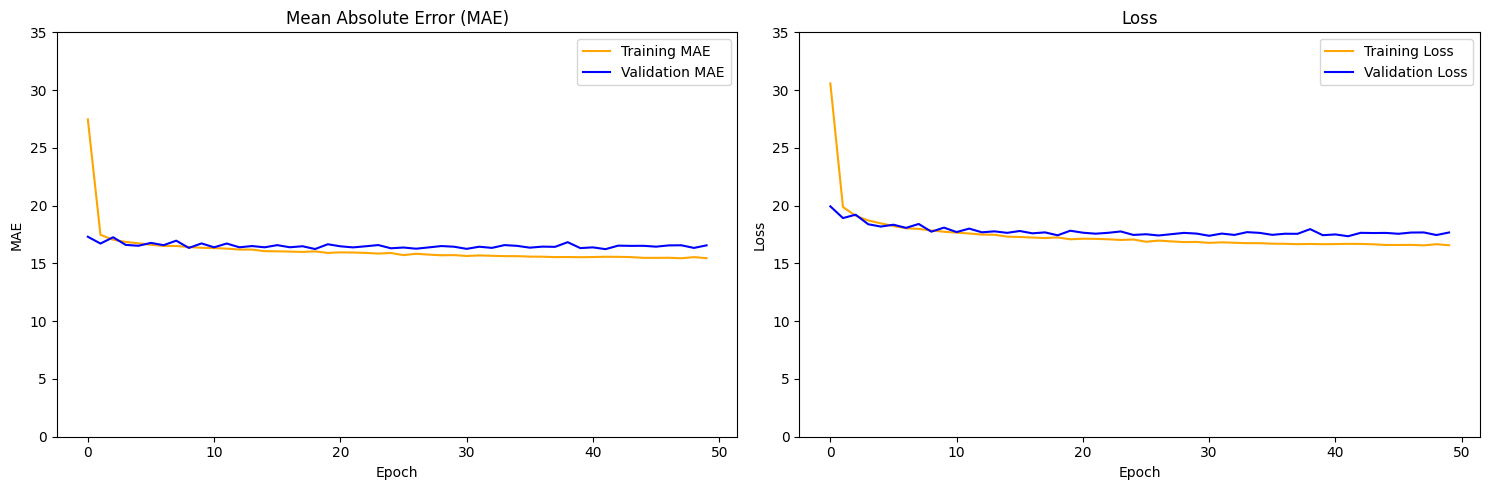

r2: 0.12543223296616157


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 35)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 35)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

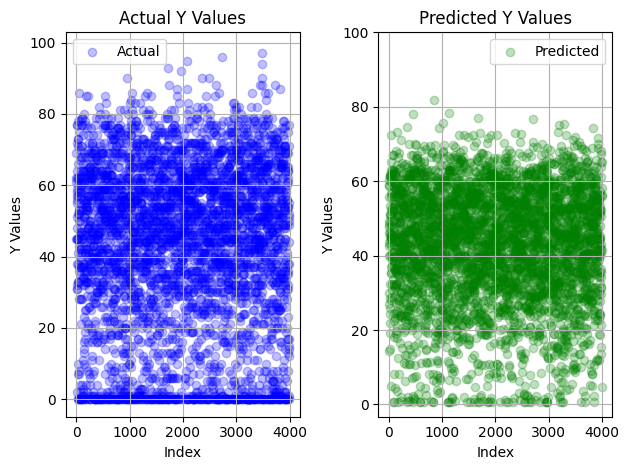

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

It's overfitting little. Let's change the regularization alpha, add more epochs as the loss and MAE were slowly decreasing.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model2 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l1(0.05) #this is stronger

# Declare the hidden layers
model2.add(layers.Dense(69, activation="relu", kernel_regularizer=regularizer))
model2.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizer)) # this is new
model2.add(layers.Dropout(0.2)) # this is new
model2.add(layers.Dense(35, activation="relu", kernel_regularizer=regularizer))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model2.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model2.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model2.predict(X_test)

Epoch 1/100
500/500 [==============================] - 7s 7ms/step - loss: 43.9695 - mean_absolute_error: 30.7641 - val_loss: 27.2657 - val_mean_absolute_error: 23.5359
Epoch 2/100
500/500 [==============================] - 4s 9ms/step - loss: 22.3449 - mean_absolute_error: 18.9004 - val_loss: 28.9341 - val_mean_absolute_error: 25.7171
Epoch 3/100
500/500 [==============================] - 3s 6ms/step - loss: 21.3826 - mean_absolute_error: 18.3788 - val_loss: 26.4544 - val_mean_absolute_error: 23.6243
Epoch 4/100
500/500 [==============================] - 3s 6ms/step - loss: 20.9357 - mean_absolute_error: 18.2557 - val_loss: 25.1392 - val_mean_absolute_error: 22.6002
Epoch 5/100
500/500 [==============================] - 2s 5ms/step - loss: 20.5383 - mean_absolute_error: 18.1177 - val_loss: 23.1624 - val_mean_absolute_error: 20.8402
Epoch 6/100
500/500 [==============================] - 3s 6ms/step - loss: 20.2150 - mean_absolute_error: 17.9892 - val_loss: 24.0802 - val_mean_absolute_e

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 69)                4830      
                                                                 
 dense_5 (Dense)             (None, 50)                3500      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 35)                1785      
                                                                 
 batch_normalization_2 (Bat  (None, 35)                140       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                360       
                                                      

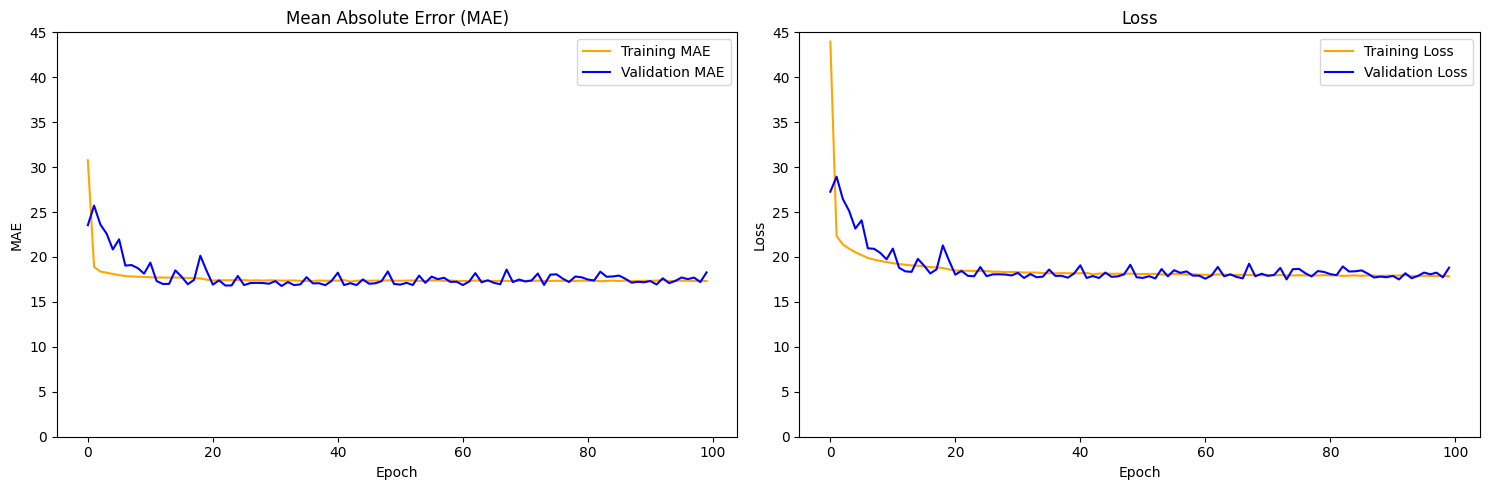

r2: 0.0953929689356523


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 45)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 45)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

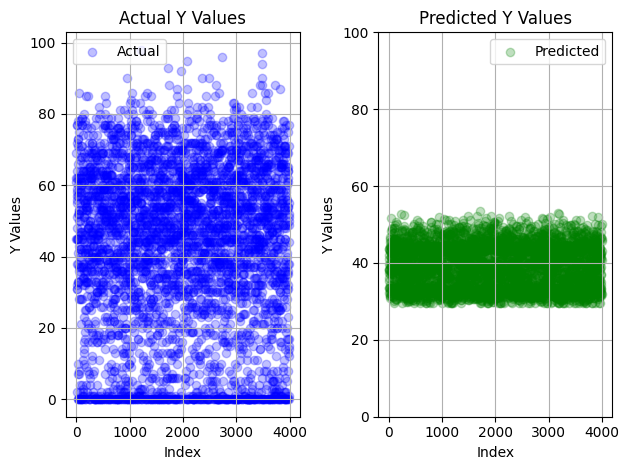

In [ ]:


# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

Now the validation MAE is lower than training MAE! Increasing the alpha has worked. Let's add more layers, but we can reduce the epochs to 50.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model3 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l1(0.05)

# Declare the hidden layers
model3.add(layers.Dense(69, activation="relu", kernel_regularizer=regularizer))
model3.add(layers.Dense(60, activation="relu", kernel_regularizer=regularizer)) # this is new
model3.add(layers.BatchNormalization()) # this is new
model3.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizer))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(35, activation="relu", kernel_regularizer=regularizer))
model3.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer)) # this is new
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model3.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model3.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model3.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model3.predict(X_test)

Epoch 1/50
500/500 [==============================] - 4s 5ms/step - loss: 51.9122 - mean_absolute_error: 28.7013 - val_loss: 31.4986 - val_mean_absolute_error: 24.3181
Epoch 2/50
500/500 [==============================] - 4s 8ms/step - loss: 25.8745 - mean_absolute_error: 19.6493 - val_loss: 24.1631 - val_mean_absolute_error: 18.6175
Epoch 3/50
500/500 [==============================] - 2s 3ms/step - loss: 23.5027 - mean_absolute_error: 18.7180 - val_loss: 21.7552 - val_mean_absolute_error: 17.5602
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 21.5678 - mean_absolute_error: 17.7372 - val_loss: 20.5701 - val_mean_absolute_error: 17.1265
Epoch 5/50
500/500 [==============================] - 2s 4ms/step - loss: 20.6605 - mean_absolute_error: 17.4636 - val_loss: 19.9190 - val_mean_absolute_error: 16.9458
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 20.1691 - mean_absolute_error: 17.3829 - val_loss: 19.6116 - val_mean_absolute_error: 

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 69)                4830      
                                                                 
 dense_10 (Dense)            (None, 60)                4200      
                                                                 
 batch_normalization_3 (Bat  (None, 60)                240       
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 50)                3050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 35)                1785      
                                                      

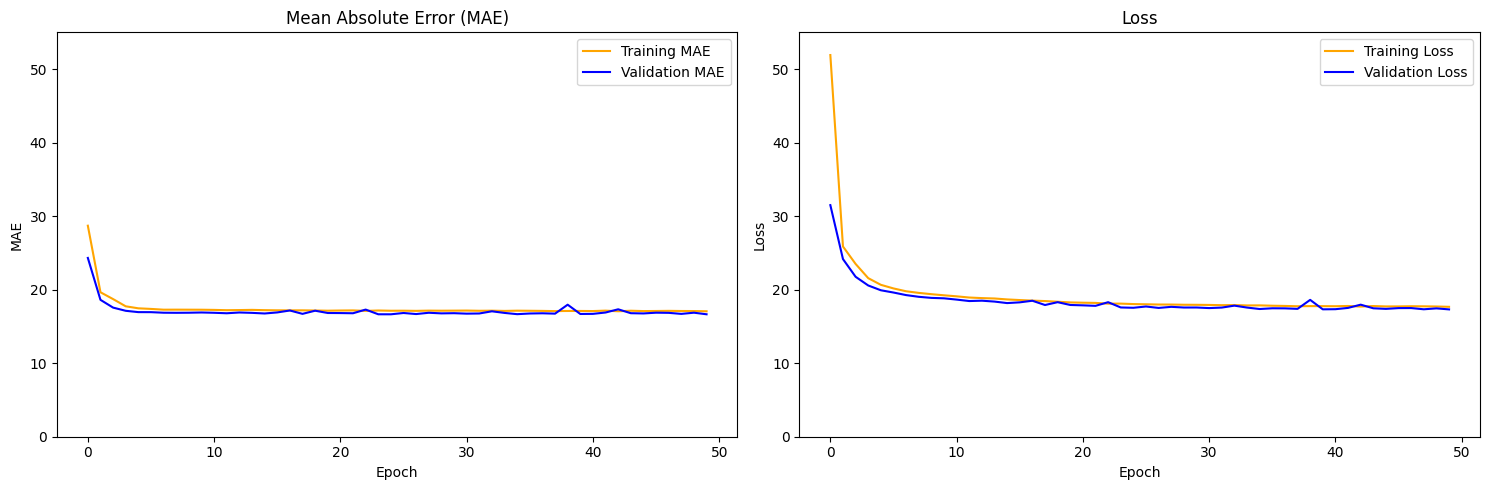

r2: 0.1331682812446603


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

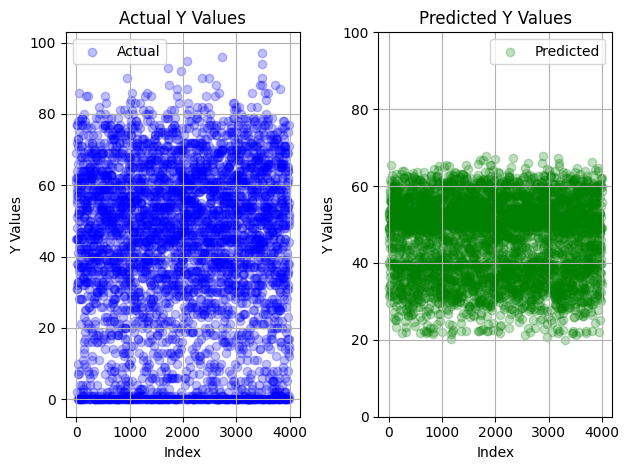

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

Now let's build something with more layers.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model4 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l1(0.05)

# Declare the hidden layers
model4.add(layers.Dense(69, activation="relu", kernel_regularizer=regularizer))
model4.add(layers.Dense(60, activation="relu", kernel_regularizer=regularizer))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizer))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer)) # this is new
model4.add(layers.Dense(30, activation="relu", kernel_regularizer=regularizer)) # this was 35
model4.add(layers.Dropout(0.2)) # this is new
model4.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model4.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model4.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model4.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model4.predict(X_test)

Epoch 1/50
500/500 [==============================] - 5s 4ms/step - loss: 52.1669 - mean_absolute_error: 31.3853 - val_loss: 29.7282 - val_mean_absolute_error: 24.7332
Epoch 2/50
500/500 [==============================] - 2s 3ms/step - loss: 23.2415 - mean_absolute_error: 19.0309 - val_loss: 31.8563 - val_mean_absolute_error: 28.2413
Epoch 3/50
500/500 [==============================] - 2s 3ms/step - loss: 21.8066 - mean_absolute_error: 18.4336 - val_loss: 29.9992 - val_mean_absolute_error: 26.8520
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 21.2142 - mean_absolute_error: 18.2796 - val_loss: 25.3899 - val_mean_absolute_error: 22.6270
Epoch 5/50
500/500 [==============================] - 2s 3ms/step - loss: 20.7935 - mean_absolute_error: 18.1876 - val_loss: 23.9911 - val_mean_absolute_error: 21.5210
Epoch 6/50
500/500 [==============================] - 2s 4ms/step - loss: 20.2998 - mean_absolute_error: 17.9337 - val_loss: 20.8944 - val_mean_absolute_error: 

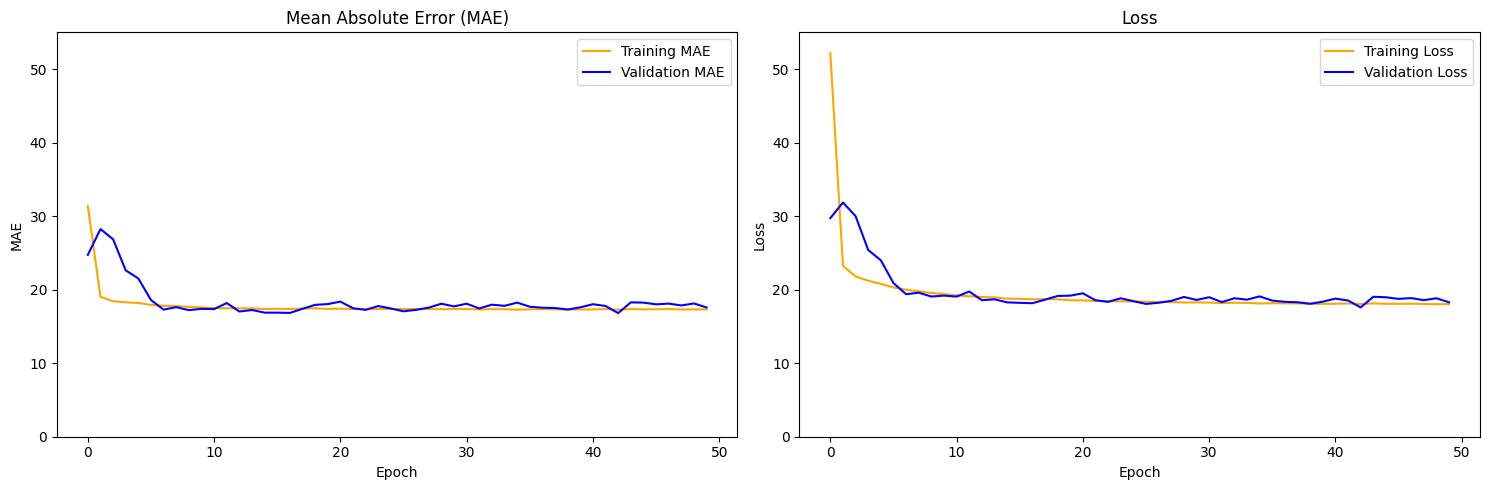

r2: 0.13500533687969896


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

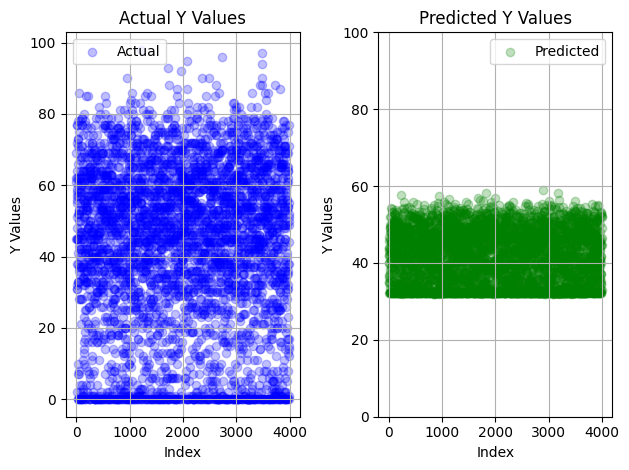

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

Adding more layers did not necessarily improve the MAE and r2 scores so far. I want to go back to the first model which had less layers and change it only slightly.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model5 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l1(0.05)

# Declare the hidden layers
model5.add(layers.Dense(69, activation="relu", kernel_regularizer=regularizer))
model5.add(layers.BatchNormalization())
model5.add(layers.Dense(36, activation="relu", kernel_regularizer=regularizer)) # this was 35
model5.add(layers.BatchNormalization())
model5.add(layers.Dense(18, activation="relu", kernel_regularizer=regularizer)) # this was 10
model5.add(layers.BatchNormalization()) # this is new
model5.add(layers.Dense(9, activation="relu", kernel_regularizer=regularizer)) # this is new

# Declare the output layer
# Single node output as this is regression
model5.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model5.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model5.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model5.predict(X_test)

Epoch 1/50
500/500 [==============================] - 8s 5ms/step - loss: 43.9919 - mean_absolute_error: 31.4587 - val_loss: 24.4484 - val_mean_absolute_error: 19.0829
Epoch 2/50
500/500 [==============================] - 2s 3ms/step - loss: 23.5482 - mean_absolute_error: 18.5522 - val_loss: 23.1107 - val_mean_absolute_error: 18.7929
Epoch 3/50
500/500 [==============================] - 1s 3ms/step - loss: 21.6730 - mean_absolute_error: 17.7948 - val_loss: 20.7403 - val_mean_absolute_error: 17.3380
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 20.6190 - mean_absolute_error: 17.4681 - val_loss: 19.9567 - val_mean_absolute_error: 17.0791
Epoch 5/50
500/500 [==============================] - 1s 3ms/step - loss: 19.9869 - mean_absolute_error: 17.3008 - val_loss: 19.2171 - val_mean_absolute_error: 16.7719
Epoch 6/50
500/500 [==============================] - 2s 4ms/step - loss: 19.5035 - mean_absolute_error: 17.1506 - val_loss: 19.2558 - val_mean_absolute_error: 

In [ ]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 69)                4830      
                                                                 
 batch_normalization_9 (Bat  (None, 69)                276       
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 36)                2520      
                                                                 
 batch_normalization_10 (Ba  (None, 36)                144       
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            (None, 18)                666       
                                                                 
 batch_normalization_11 (Ba  (None, 18)               

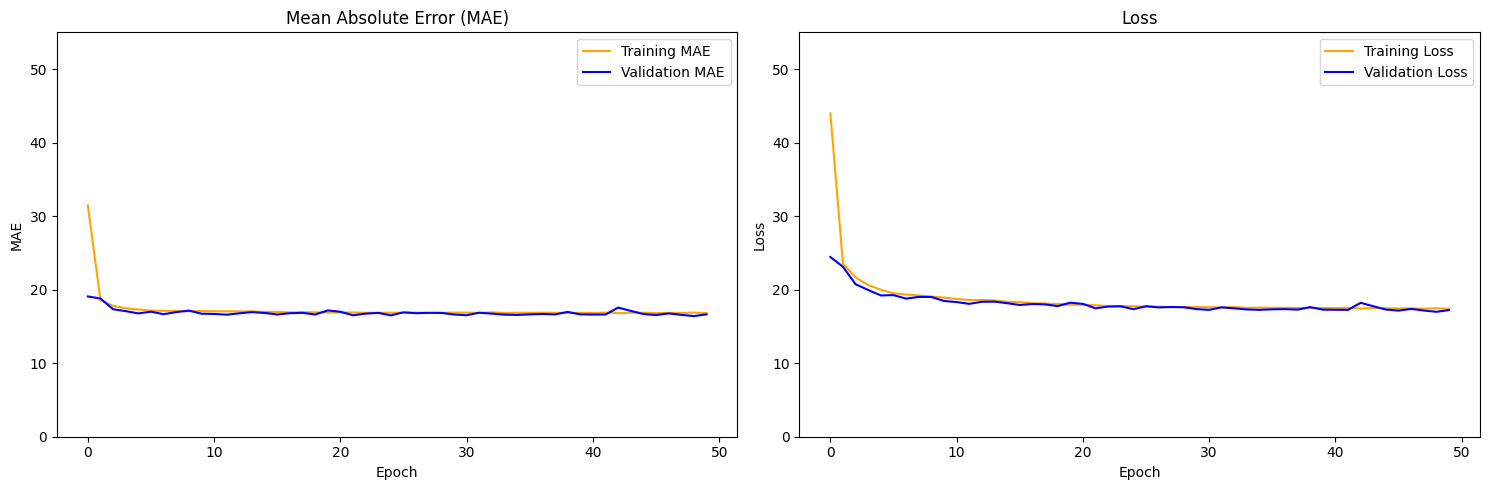

r2: 0.1408966372207895


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

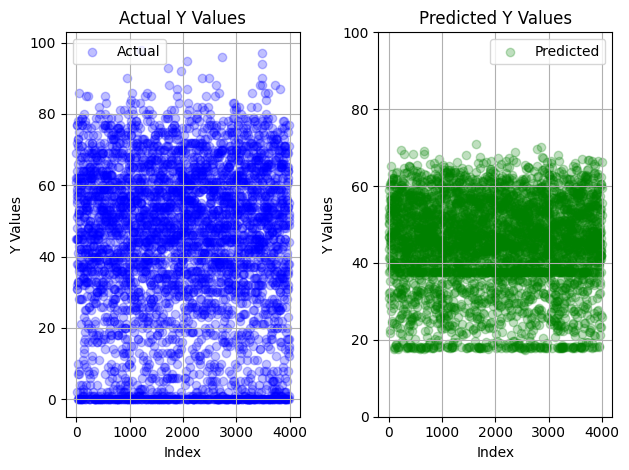

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model6 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l1(0.05)

# Declare the hidden layers
model6.add(layers.Dense(69, activation="relu", kernel_regularizer=regularizer))
model6.add(layers.BatchNormalization())
model6.add(layers.Dense(36, activation="relu", kernel_regularizer=regularizer))
model6.add(layers.Dropout(0.2)) # this is new
model6.add(layers.Dense(18, activation="relu", kernel_regularizer=regularizer))
model6.add(layers.BatchNormalization())
model6.add(layers.Dense(9, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model6.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model6.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model6.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model6.predict(X_test)

Epoch 1/50
500/500 [==============================] - 4s 4ms/step - loss: 44.9989 - mean_absolute_error: 33.5771 - val_loss: 23.6947 - val_mean_absolute_error: 19.3779
Epoch 2/50
500/500 [==============================] - 2s 3ms/step - loss: 22.9175 - mean_absolute_error: 18.9497 - val_loss: 20.9826 - val_mean_absolute_error: 17.4802
Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 20.8758 - mean_absolute_error: 17.7503 - val_loss: 20.6992 - val_mean_absolute_error: 17.7712
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 20.1298 - mean_absolute_error: 17.4568 - val_loss: 19.3629 - val_mean_absolute_error: 16.9579
Epoch 5/50
500/500 [==============================] - 1s 3ms/step - loss: 19.7951 - mean_absolute_error: 17.4258 - val_loss: 19.1044 - val_mean_absolute_error: 16.8226
Epoch 6/50
500/500 [==============================] - 1s 3ms/step - loss: 19.6129 - mean_absolute_error: 17.3847 - val_loss: 18.9370 - val_mean_absolute_error: 

In [ ]:
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 69)                4830      
                                                                 
 batch_normalization_14 (Ba  (None, 69)                276       
 tchNormalization)                                               
                                                                 
 dense_43 (Dense)            (None, 36)                2520      
                                                                 
 dropout_7 (Dropout)         (None, 36)                0         
                                                                 
 dense_44 (Dense)            (None, 18)                666       
                                                                 
 batch_normalization_15 (Ba  (None, 18)                72        
 tchNormalization)                                    

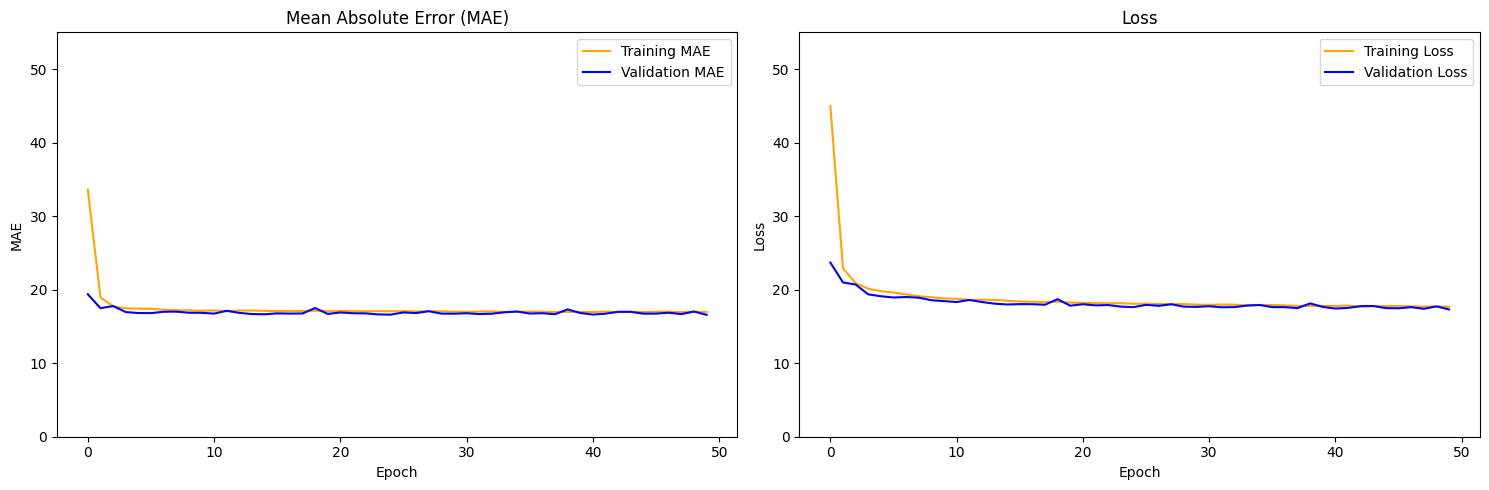

r2: 0.13203900521580303


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

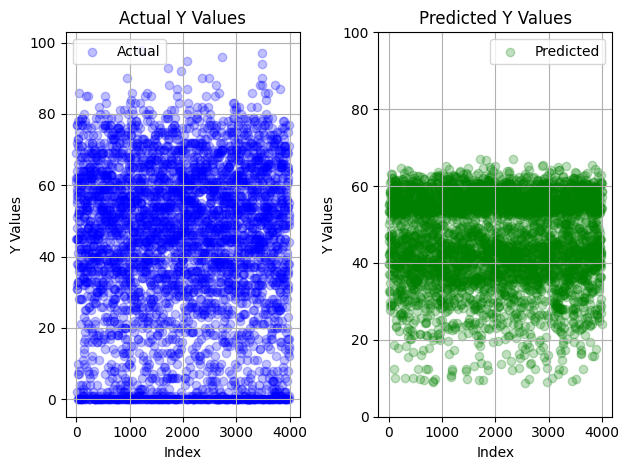

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

Let's build a linear regression with all the features, then get the coefficients for future selection and build other neural nets.

## Part 2: Modeling with top 59 features

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tempfile import mkdtemp
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
# Define the pipeline with estimators
estimators = [
    ('scaling', None), # the data is already scaled
    ('dimred', PCA()),  # Dimensionality reduction using PCA
    ('model', Lasso())  # Lasso linear regression
]

# Create the pipeline
pipe = Pipeline(estimators)

# Caching for the pipeline
cachedir = mkdtemp()
cached_pipe = Pipeline(estimators, memory=cachedir)

# Define parameter distributions
param_grid = [
    {
        'dimred__n_components': [0.9, 0.5, None],  # Percentage of variance or None for no reduction
        'model': [Lasso()],  # Lasso regression
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Example values for Lasso alpha
    },
    {
        'dimred__n_components': [0.9, 0.5, None],  # Percentage of variance or None for no reduction
        'model': [Ridge()],  # Ridge regression
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Example values for Ridge alpha
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']  # Solvers appropriate for Ridge
    }
]

# Initialize GridSearchCV
grid = GridSearchCV(cached_pipe, param_grid, cv=5)

# Fit the grid search on the training data
fitted_grid = grid.fit(X_train, y_train)

# Get the best model from the grid search
best_model1 = grid.best_estimator_

# Use the best model to make predictions on the test set
y_pred_test = best_model1.predict(X_test)

# Calculate the mean absolute error (MAE) on the test set
test_mae = mean_absolute_error(y_test, y_pred_test)

# Get test R-squared
test_r2 = r2_score(y_test, y_pred_test)

# Use the best model to make predictions on the training set
y_pred_train = best_model1.predict(X_train)

# Calculate the training R-squared
train_r2 = r2_score(y_train, y_pred_train)

# Print the best parameters and test scores
print("Best Parameters:", fitted_grid.best_params_)
print("Model1 Training R-squared:", train_r2)
print("Model1 Test MAE:", test_mae)
print("Model1 Test R-squared:", test_r2)

Best Parameters: {'dimred__n_components': None, 'model': Ridge(alpha=1, solver='lsqr'), 'model__alpha': 1, 'model__solver': 'lsqr'}
Model1 Training R-squared: 0.16964288266996186
Model1 Test MAE: 17.00436132679775
Model1 Test R-squared: 0.16452227314488543


The best model is a Ridge linear regression with alpha=1 and solver lsqr, R-squared scores: 0.169(training) and 0.164(test). MAE: 17

In [ ]:
best_model1.named_steps.model.coef_ # get the coefficients

array([ -1.6157831 ,  -1.08636242,  -1.63976712,  -2.892532  ,
        -1.16077217,   3.01908867,  -1.79278245,  -1.10551739,
        -1.09542119,   2.63913648,  -0.15282132,   0.35832501,
         2.19130769,   4.45406264,  -1.35114382,   1.1844237 ,
         0.5928117 ,  -0.17905998,   2.21448626,   0.43409576,
        -1.43449308,   5.0280004 ,  -6.12010188,  -3.96244028,
         6.77254463,  -8.3713964 ,  -7.66206571,  -0.91094462,
         0.59036148,   2.37883475,   1.54845371,   7.67619591,
         9.25707108, -13.63214646,  -7.03735279,   3.69941325,
        -1.52757121,   3.87997694,  15.6161095 ,   5.71251409,
         8.3812022 ,  -0.25838973,   2.52140947,   9.45636566,
         2.66973713,   0.6950971 ,   0.90202484,   9.1966974 ,
         0.52136404, -10.60075884,  -5.26678196,   3.33513693,
        -8.6479398 ,   4.50601639,   0.23075568,  11.89099453,
       -16.97329063,   0.40205204,   8.1751403 ,  -0.75078805,
        -2.67123974,   1.64929927,  -9.50751876,   0.47

Let's build this linear regression from sklearn and get the coefficients and feature names. It seems not to be possible with a pipeline object.

In [ ]:
# Instantiate the Ridge regression model
ridge_model = Ridge(alpha=1.0, solver='lsqr', random_state=1)

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Predict on the test data
y_pred = ridge_model.predict(X_test)

# Evaluate the model
MAE = mean_absolute_error(y_test, y_pred)
MAE

17.004261456907717

<Figure size 1800x1400 with 0 Axes>

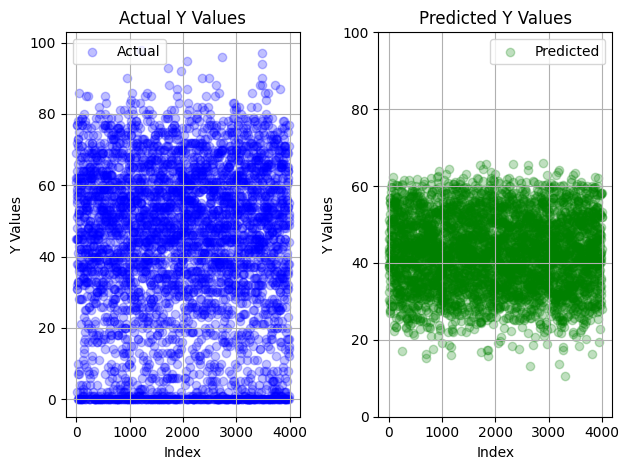

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

In [ ]:
# get feature names out
feature_names = ridge_model.feature_names_in_.tolist()

# get coefficients
coefficients = ridge_model.coef_

# calculate odds ratios
odds_ratios = np.exp(coefficients)

# create DataFrame for feature names and odds ratios
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficients': coefficients, 'Odds Ratio': odds_ratios})

coef_df.head()

Feature  Coefficients    Odds Ratio
0      Clear      1.826499  6.212099e+00
1  Relatable      5.589504  2.676028e+02
2  Memorable     19.522416  3.009384e+08
3   Engaging     -1.369560  2.542188e-01
4   Symbolic     -9.254891  9.564272e-05

In [ ]:
# sort the DataFrame by coefficients in descending order
coef_df_sorted = coef_df.sort_values("Coefficients", ascending=False)

# check top ten
top_ten_pos = coef_df_sorted.head(10)
top_ten_pos

Feature  Coefficients    Odds Ratio
2                          Memorable     19.522416  3.009384e+08
12                      danceability     12.461495  2.582014e+05
43  playlist_subgenre_permanent wave      7.205007  1.346154e+03
67                   lang_Portuguese      7.083551  1.192194e+03
45   playlist_subgenre_post-teen pop      6.119976  4.548536e+02
1                          Relatable      5.589504  2.676028e+02
36         playlist_subgenre_hip hop      5.553908  2.582447e+02
22                 album_decade_1970      5.027648  1.525737e+02
21                 album_decade_1960      4.553548  9.496879e+01
23                 album_decade_1980      4.241517  6.951322e+01

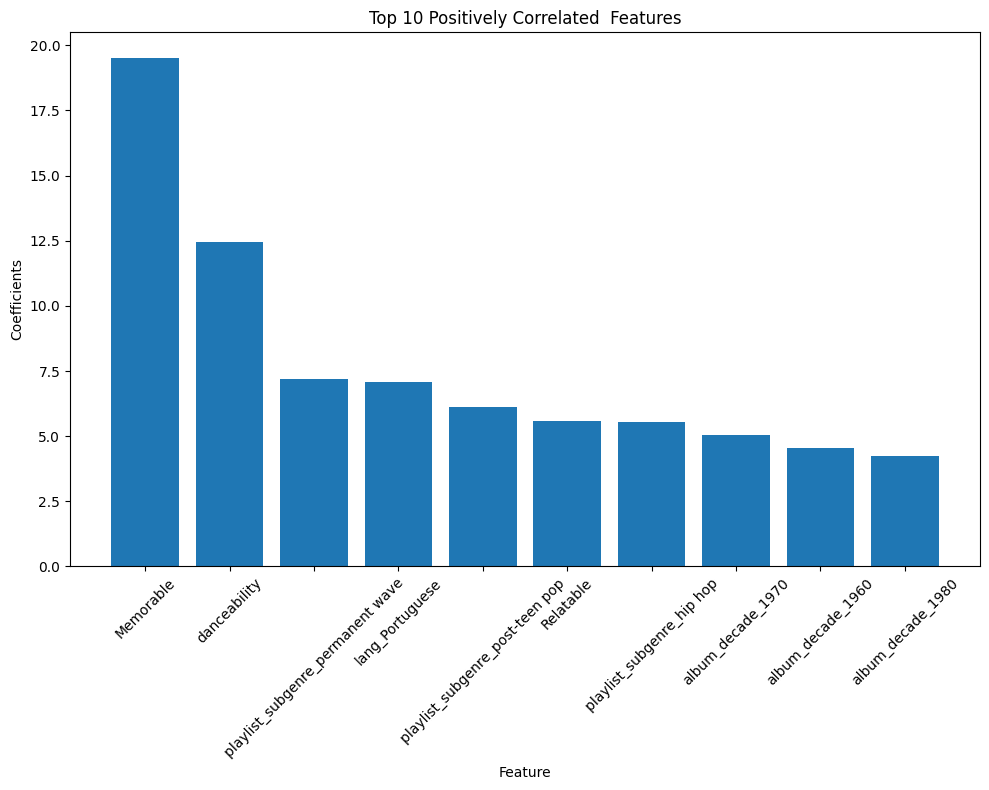

In [ ]:
# Create a bar plot for odds ratios
plt.figure(figsize=(10, 8))
plt.bar(top_ten_pos["Feature"], top_ten_pos["Coefficients"])
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.xlabel("Feature")
plt.title("Top 10 Positively Correlated  Features")
plt.tight_layout()
plt.show()

In [ ]:
# check bottom ten
coef_df_sorted.tail(10)

Feature  Coefficients    Odds Ratio
17                                  duration_ms     -9.311054  9.041918e-05
32              playlist_subgenre_electro house    -10.290798  3.394403e-05
39              playlist_subgenre_latin hip hop    -11.597010  9.193539e-06
47           playlist_subgenre_southern hip hop    -11.859869  7.068453e-06
44                    playlist_subgenre_pop edm    -13.236740  1.783844e-06
34               playlist_subgenre_gangster rap    -13.805814  1.009744e-06
41                   playlist_subgenre_neo soul    -15.126859  2.694565e-07
29                   playlist_subgenre_big room    -16.023637  1.099063e-07
42             playlist_subgenre_new jack swing    -19.624982  2.999014e-09
46  playlist_subgenre_progressive electro house    -20.549327  1.189982e-09

In [ ]:
low_coef_df = coef_df_sorted[(coef_df_sorted['Coefficients'] < 0.6) & (coef_df_sorted['Coefficients'] > -0.6)] # filter for below 0.6 and above -0.6 (near 0) coefficients
low_coef_df

Feature  Coefficients  Odds Ratio
57            key_7      0.530130    1.699152
51            key_0      0.496534    1.643017
54            key_4      0.213141    1.237559
60           key_10      0.193441    1.213417
59            key_9      0.163791    1.177968
53            key_2      0.088810    1.092873
14             mode      0.080700    1.084046
62  log_speechiness      0.076654    1.079668
9             Angry     -0.054589    0.946874
65     log_liveness     -0.362743    0.695765

In [ ]:
to_drop = low_coef_df['Feature'] # get the low coef features in a list
cols_to_drop = to_drop.tolist() # check the list

In [ ]:
print(cols_to_drop)

['key_7', 'key_0', 'key_4', 'key_9', 'key_10', 'mode', 'log_speechiness', 'key_2', 'Angry', 'log_liveness']


Let's drop these from the training data!

In [ ]:
# let's save each as backup first
X_train.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/X_train.csv')
y_train.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/y_train.csv')
X_test.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/X_test.csv')
y_test.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/y_test.csv')

In [ ]:
X_train.drop(columns=['key_7', 'key_0', 'key_4', 'key_9', 'key_10', 'mode', 'log_speechiness', 'key_2', 'Angry', 'log_liveness'], inplace=True)
X_train.columns

Index(['Clear', 'Relatable', 'Memorable', 'Engaging', 'Symbolic', 'Lyrical',
       'Happy', 'Surprised', 'Fearful', 'Disgusted', 'Sad', 'danceability',
       'loudness', 'valence', 'tempo', 'duration_ms',
       'album_release_quarter_1', 'album_release_quarter_3',
       'album_release_quarter_4', 'album_decade_1960', 'album_decade_1970',
       'album_decade_1980', 'album_decade_1990', 'album_decade_2000',
       'album_decade_2010', 'album_decade_2020',
       'playlist_subgenre_album rock', 'playlist_subgenre_big room',
       'playlist_subgenre_classic rock', 'playlist_subgenre_dance pop',
       'playlist_subgenre_electro house', 'playlist_subgenre_electropop',
       'playlist_subgenre_gangster rap', 'playlist_subgenre_hard rock',
       'playlist_subgenre_hip hop', 'playlist_subgenre_hip pop',
       'playlist_subgenre_indie poptimism', 'playlist_subgenre_latin hip hop',
       'playlist_subgenre_latin pop', 'playlist_subgenre_neo soul',
       'playlist_subgenre_new jack swi

In [ ]:
X_train.shape # now there are 59 features in the training data

(15980, 59)

In [ ]:
X_test.drop(columns=['key_7', 'key_0', 'key_4', 'key_9', 'key_10', 'mode', 'log_speechiness', 'key_2', 'Angry', 'log_liveness'], inplace=True)
X_test.columns

Index(['Clear', 'Relatable', 'Memorable', 'Engaging', 'Symbolic', 'Lyrical',
       'Happy', 'Surprised', 'Fearful', 'Disgusted', 'Sad', 'danceability',
       'loudness', 'valence', 'tempo', 'duration_ms',
       'album_release_quarter_1', 'album_release_quarter_3',
       'album_release_quarter_4', 'album_decade_1960', 'album_decade_1970',
       'album_decade_1980', 'album_decade_1990', 'album_decade_2000',
       'album_decade_2010', 'album_decade_2020',
       'playlist_subgenre_album rock', 'playlist_subgenre_big room',
       'playlist_subgenre_classic rock', 'playlist_subgenre_dance pop',
       'playlist_subgenre_electro house', 'playlist_subgenre_electropop',
       'playlist_subgenre_gangster rap', 'playlist_subgenre_hard rock',
       'playlist_subgenre_hip hop', 'playlist_subgenre_hip pop',
       'playlist_subgenre_indie poptimism', 'playlist_subgenre_latin hip hop',
       'playlist_subgenre_latin pop', 'playlist_subgenre_neo soul',
       'playlist_subgenre_new jack swi

In [ ]:
X_test.shape # now there are 59 features in the testing data

(3995, 59)

Let's build a neural net. I will start by re-running the best one so far.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model6b = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l1(0.05)

# Declare the hidden layers
model6b.add(layers.Dense(59, activation="relu", kernel_regularizer=regularizer)) # this was 69
model6b.add(layers.BatchNormalization())
model6b.add(layers.Dense(36, activation="relu", kernel_regularizer=regularizer))
model6b.add(layers.Dropout(0.2))
model6b.add(layers.Dense(18, activation="relu", kernel_regularizer=regularizer))
model6b.add(layers.BatchNormalization())
model6b.add(layers.Dense(9, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model6b.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model6b.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model6b.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model6b.predict(X_test)

Epoch 1/50
500/500 [==============================] - 10s 7ms/step - loss: 43.5484 - mean_absolute_error: 30.5910 - val_loss: 26.9154 - val_mean_absolute_error: 21.2900
Epoch 2/50
500/500 [==============================] - 5s 9ms/step - loss: 23.3196 - mean_absolute_error: 18.3851 - val_loss: 21.5925 - val_mean_absolute_error: 17.5018
Epoch 3/50
500/500 [==============================] - 5s 10ms/step - loss: 21.3205 - mean_absolute_error: 17.6435 - val_loss: 20.3003 - val_mean_absolute_error: 16.9841
Epoch 4/50
500/500 [==============================] - 4s 7ms/step - loss: 20.5473 - mean_absolute_error: 17.4076 - val_loss: 20.1076 - val_mean_absolute_error: 17.1178
Epoch 5/50
500/500 [==============================] - 3s 6ms/step - loss: 20.1892 - mean_absolute_error: 17.3783 - val_loss: 19.3902 - val_mean_absolute_error: 16.8213
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 19.7937 - mean_absolute_error: 17.3227 - val_loss: 19.2855 - val_mean_absolute_error

In [ ]:
model6b.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 59)                3540      
                                                                 
 batch_normalization_14 (Ba  (None, 59)                236       
 tchNormalization)                                               
                                                                 
 dense_37 (Dense)            (None, 36)                2160      
                                                                 
 dropout_1 (Dropout)         (None, 36)                0         
                                                                 
 dense_38 (Dense)            (None, 18)                666       
                                                                 
 batch_normalization_15 (Ba  (None, 18)                72        
 tchNormalization)                                    

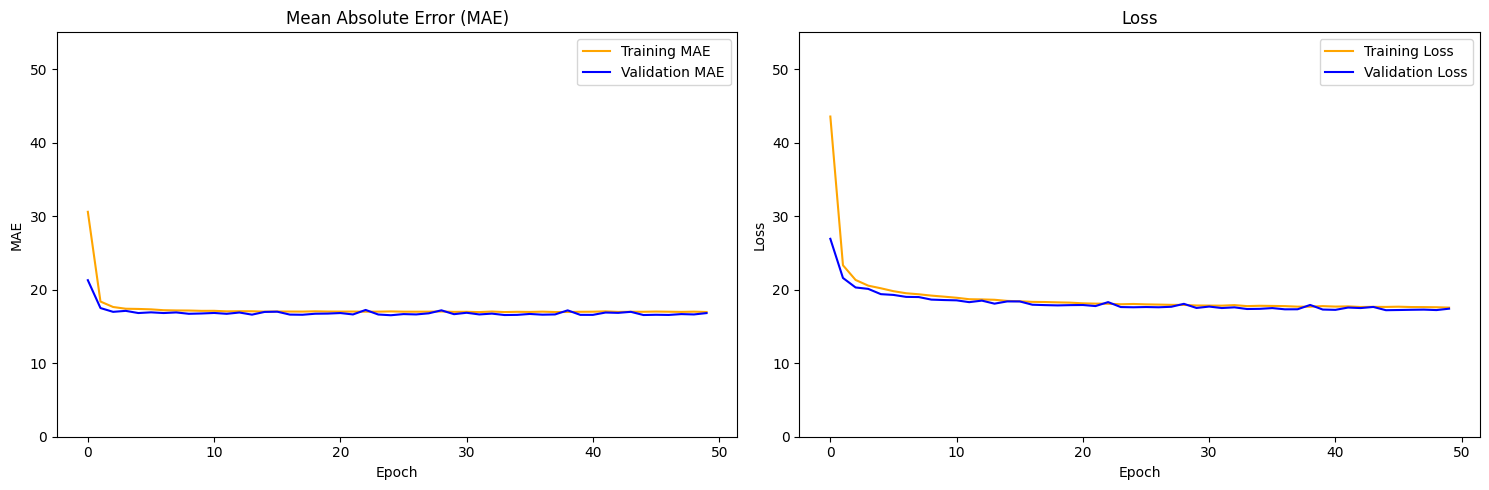

r2: 0.147171151581434


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

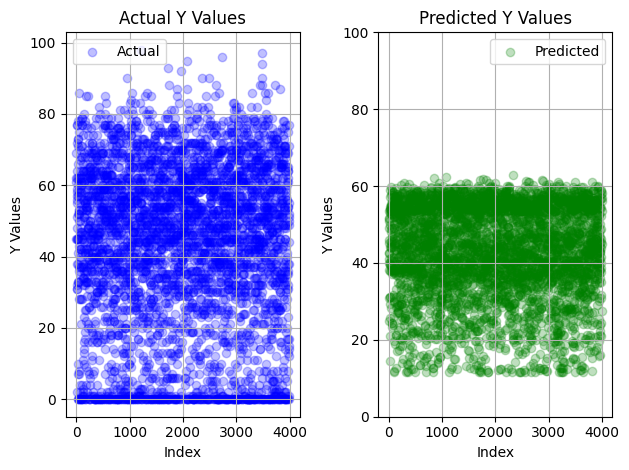

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

MAE has decreased a little, while r2 has increased. Let's try l2 regularization.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model7 = keras.Sequential()

# Create a regularizer with a factor of 0.005
regularizer = keras.regularizers.l2(0.05) # this was l1

# Declare the hidden layers
model7.add(layers.Dense(59, activation="relu", kernel_regularizer=regularizer))
model7.add(layers.BatchNormalization())
model7.add(layers.Dense(36, activation="relu", kernel_regularizer=regularizer))
# the dropout is gone
model7.add(layers.Dense(18, activation="relu", kernel_regularizer=regularizer))
model7.add(layers.BatchNormalization())
model7.add(layers.Dense(9, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model7.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model7.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model7.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model7.predict(X_test)

Epoch 1/50
500/500 [==============================] - 7s 6ms/step - loss: 33.3024 - mean_absolute_error: 29.5703 - val_loss: 21.0355 - val_mean_absolute_error: 17.9430
Epoch 2/50
500/500 [==============================] - 4s 8ms/step - loss: 20.4754 - mean_absolute_error: 17.6579 - val_loss: 19.7020 - val_mean_absolute_error: 17.1998
Epoch 3/50
500/500 [==============================] - 3s 5ms/step - loss: 19.4378 - mean_absolute_error: 17.1705 - val_loss: 18.9243 - val_mean_absolute_error: 16.8648
Epoch 4/50
500/500 [==============================] - 1s 3ms/step - loss: 18.8207 - mean_absolute_error: 16.9373 - val_loss: 18.4972 - val_mean_absolute_error: 16.7663
Epoch 5/50
500/500 [==============================] - 1s 3ms/step - loss: 18.4347 - mean_absolute_error: 16.8253 - val_loss: 18.4449 - val_mean_absolute_error: 16.9364
Epoch 6/50
500/500 [==============================] - 1s 3ms/step - loss: 18.2812 - mean_absolute_error: 16.8453 - val_loss: 18.0748 - val_mean_absolute_error: 

In [ ]:
model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 59)                3540      
                                                                 
 batch_normalization_16 (Ba  (None, 59)                236       
 tchNormalization)                                               
                                                                 
 dense_42 (Dense)            (None, 36)                2160      
                                                                 
 dense_43 (Dense)            (None, 18)                666       
                                                                 
 batch_normalization_17 (Ba  (None, 18)                72        
 tchNormalization)                                               
                                                                 
 dense_44 (Dense)            (None, 9)                

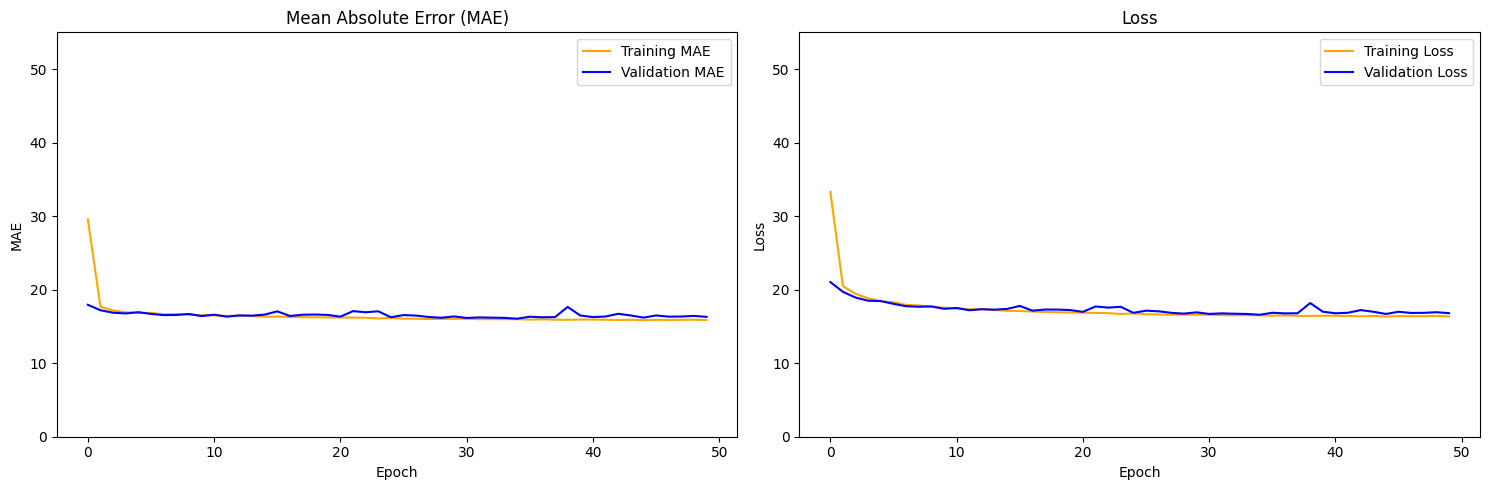

r2: 0.11959291571668207


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

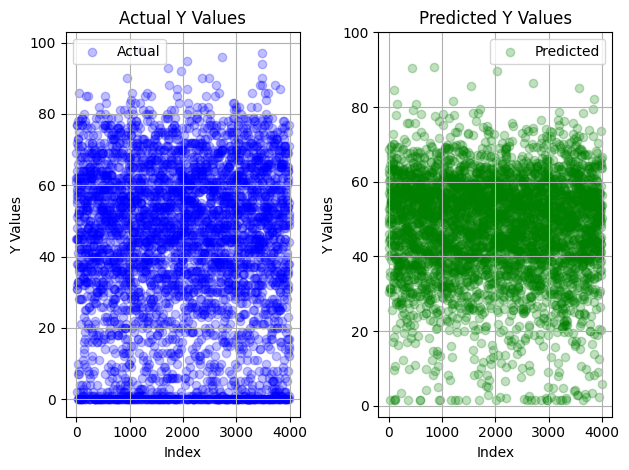

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

In terms of MAE, this is the best one so far among all.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model8 = keras.Sequential()

# Create a regularizer with a factor of 0.005
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model8.add(layers.Dense(59, activation="relu", kernel_regularizer=regularizer))
model8.add(layers.BatchNormalization())
model8.add(layers.Dense(36, activation="relu", kernel_regularizer=regularizer))
# the dropout is gone
model8.add(layers.Dense(18, activation="relu", kernel_regularizer=regularizer))
model8.add(layers.BatchNormalization())
model8.add(layers.Dense(9, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model8.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model8.compile(optimizer=tf.keras.optimizers.SGD(), # changed the optimizer
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model8.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model8.predict(X_test)

Epoch 1/50
500/500 [==============================] - 5s 4ms/step - loss: 28.4653 - mean_absolute_error: 23.3332 - val_loss: 20.8727 - val_mean_absolute_error: 17.4030
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 19.8611 - mean_absolute_error: 17.3906 - val_loss: 19.1971 - val_mean_absolute_error: 17.4632
Epoch 3/50
500/500 [==============================] - 2s 3ms/step - loss: 18.5682 - mean_absolute_error: 17.2415 - val_loss: 18.0333 - val_mean_absolute_error: 16.9938
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 18.0985 - mean_absolute_error: 17.2107 - val_loss: 18.1796 - val_mean_absolute_error: 17.4484
Epoch 5/50
500/500 [==============================] - 2s 3ms/step - loss: 17.9227 - mean_absolute_error: 17.2247 - val_loss: 17.5298 - val_mean_absolute_error: 16.8743
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 17.8687 - mean_absolute_error: 17.2309 - val_loss: 17.8853 - val_mean_absolute_error: 

In [ ]:
model8.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 59)                3540      
                                                                 
 batch_normalization_18 (Ba  (None, 59)                236       
 tchNormalization)                                               
                                                                 
 dense_47 (Dense)            (None, 36)                2160      
                                                                 
 dense_48 (Dense)            (None, 18)                666       
                                                                 
 batch_normalization_19 (Ba  (None, 18)                72        
 tchNormalization)                                               
                                                                 
 dense_49 (Dense)            (None, 9)                

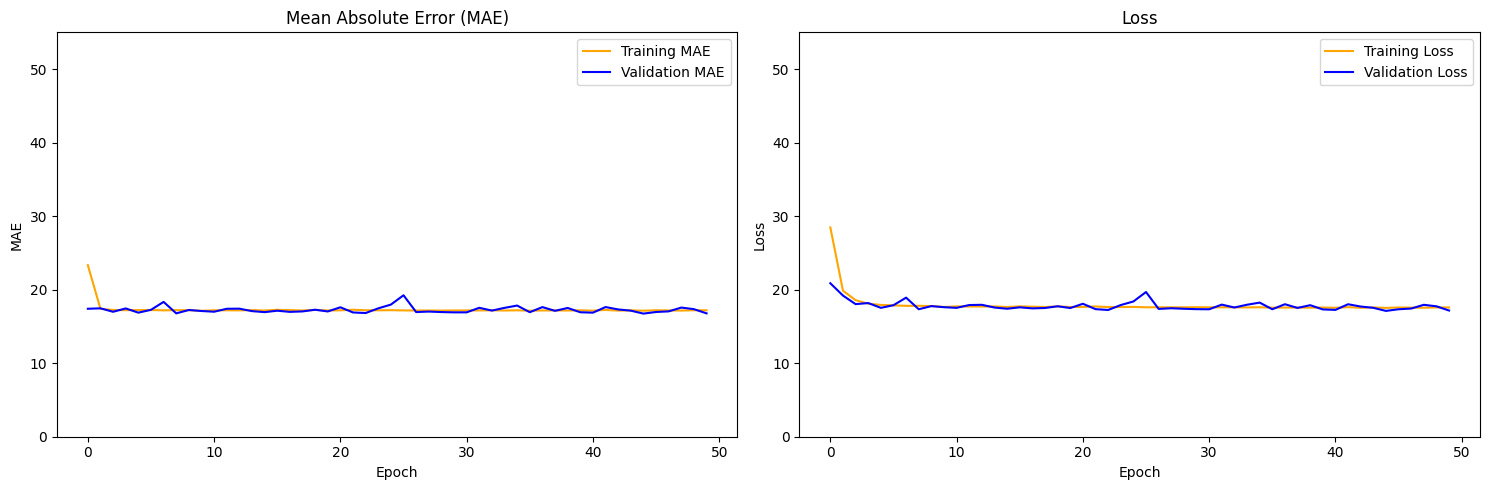

r2: 0.1406442508846074


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

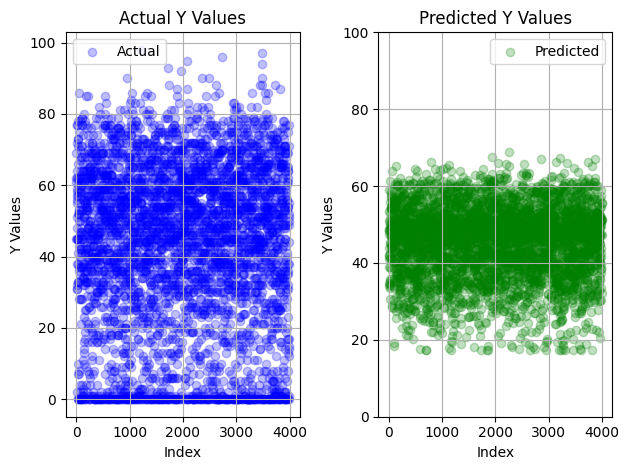

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

This is not too bad actually, r2 is better and MAE is similar. But I like Adam optimizer better (less fluctuations) so I will go back to it but try a different learning rate than the default (0.001).

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model9 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model9.add(layers.Dense(59, activation="relu", kernel_regularizer=regularizer))
model9.add(layers.BatchNormalization())
model9.add(layers.Dense(36, activation="relu", kernel_regularizer=regularizer))
# the dropout is gone
model9.add(layers.Dense(18, activation="relu", kernel_regularizer=regularizer))
model9.add(layers.BatchNormalization())
model9.add(layers.Dense(9, activation="relu", kernel_regularizer=regularizer))

# Declare the output layer
# Single node output as this is regression
model9.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # changed the learning rate and the optimizer
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model9.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model9.predict(X_test)

Epoch 1/50
500/500 [==============================] - 4s 4ms/step - loss: 23.0351 - mean_absolute_error: 20.8791 - val_loss: 18.1411 - val_mean_absolute_error: 16.9884
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 18.4063 - mean_absolute_error: 17.5410 - val_loss: 17.7801 - val_mean_absolute_error: 17.1712
Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 17.9642 - mean_absolute_error: 17.4416 - val_loss: 17.7170 - val_mean_absolute_error: 17.2861
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 17.7061 - mean_absolute_error: 17.3097 - val_loss: 17.2863 - val_mean_absolute_error: 16.9571
Epoch 5/50
500/500 [==============================] - 2s 3ms/step - loss: 17.6653 - mean_absolute_error: 17.3474 - val_loss: 20.7353 - val_mean_absolute_error: 20.4069
Epoch 6/50
500/500 [==============================] - 1s 3ms/step - loss: 17.5986 - mean_absolute_error: 17.2961 - val_loss: 18.0464 - val_mean_absolute_error: 

In [ ]:
model9.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 59)                3540      
                                                                 
 batch_normalization_22 (Ba  (None, 59)                236       
 tchNormalization)                                               
                                                                 
 dense_57 (Dense)            (None, 36)                2160      
                                                                 
 dense_58 (Dense)            (None, 18)                666       
                                                                 
 batch_normalization_23 (Ba  (None, 18)                72        
 tchNormalization)                                               
                                                                 
 dense_59 (Dense)            (None, 9)               

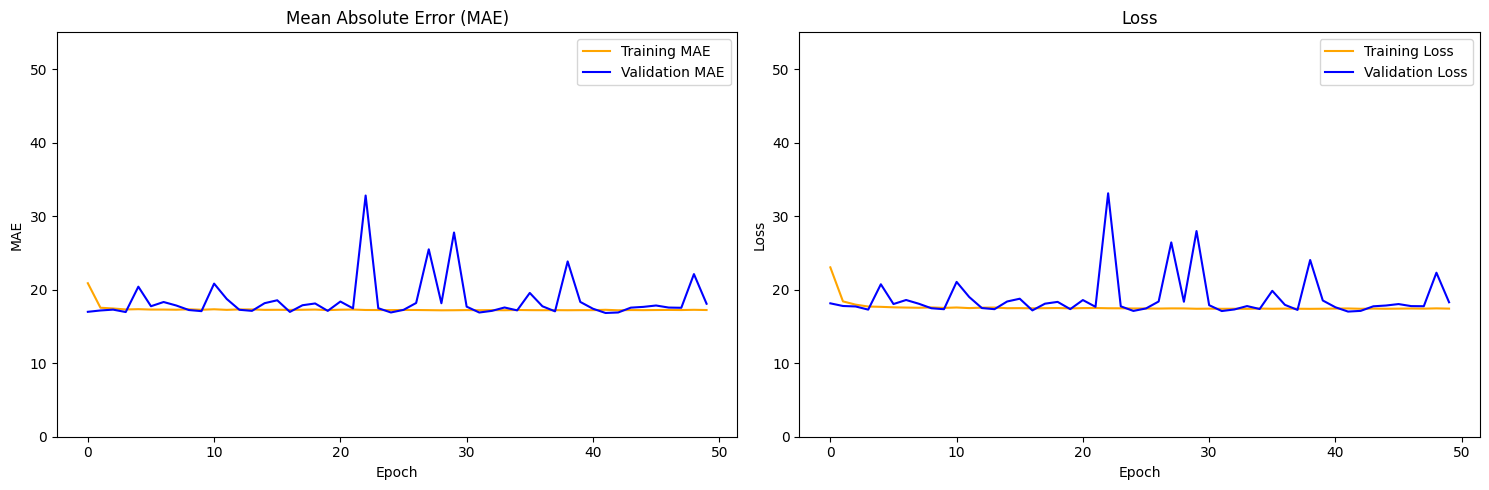

r2: 0.10942064194269707


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

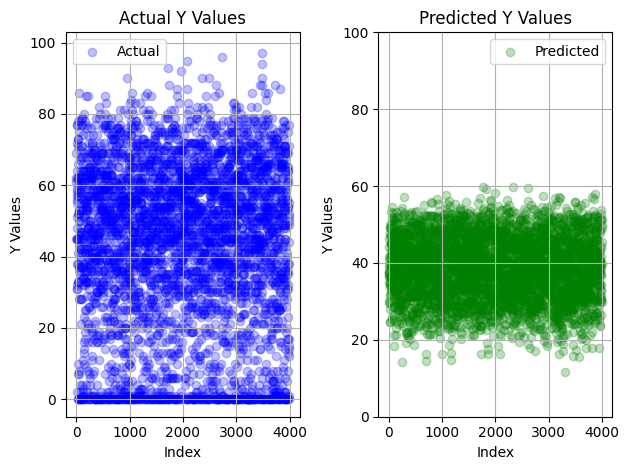

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

The training loss and MAE fuctuates a lot. I will go back to leaving the learning rate at default.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model10 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model10.add(layers.Dense(59, activation="relu", kernel_regularizer=regularizer))
model10.add(layers.BatchNormalization())
model10.add(layers.Dense(29, activation="relu", kernel_regularizer=regularizer)) # this was 36
# the dropout is gone
model10.add(layers.Dense(14, activation="relu", kernel_regularizer=regularizer)) # this was 18
model10.add(layers.BatchNormalization())
model10.add(layers.Dense(7, activation="relu", kernel_regularizer=regularizer)) # this was 9
model10.add(layers.BatchNormalization()) # this is new


# Declare the output layer
# Single node output as this is regression
model10.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model10.compile(optimizer=tf.keras.optimizers.Adam(), # back to default learning rate
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model10.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model10.predict(X_test)

Epoch 1/50
500/500 [==============================] - 4s 4ms/step - loss: 42.7225 - mean_absolute_error: 40.7248 - val_loss: 39.6122 - val_mean_absolute_error: 38.9375
Epoch 2/50
500/500 [==============================] - 1s 3ms/step - loss: 34.1970 - mean_absolute_error: 33.7010 - val_loss: 27.1151 - val_mean_absolute_error: 26.7150
Epoch 3/50
500/500 [==============================] - 2s 3ms/step - loss: 24.7218 - mean_absolute_error: 24.3482 - val_loss: 20.6674 - val_mean_absolute_error: 20.3062
Epoch 4/50
500/500 [==============================] - 1s 3ms/step - loss: 18.6806 - mean_absolute_error: 18.3237 - val_loss: 17.2782 - val_mean_absolute_error: 16.9300
Epoch 5/50
500/500 [==============================] - 2s 3ms/step - loss: 17.3307 - mean_absolute_error: 16.9881 - val_loss: 16.9042 - val_mean_absolute_error: 16.5734
Epoch 6/50
500/500 [==============================] - 2s 4ms/step - loss: 17.1496 - mean_absolute_error: 16.8230 - val_loss: 16.9273 - val_mean_absolute_error: 

In [ ]:
model10.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 59)                3540      
                                                                 
 batch_normalization_29 (Ba  (None, 59)                236       
 tchNormalization)                                               
                                                                 
 dense_67 (Dense)            (None, 29)                1740      
                                                                 
 dense_68 (Dense)            (None, 14)                420       
                                                                 
 batch_normalization_30 (Ba  (None, 14)                56        
 tchNormalization)                                               
                                                                 
 dense_69 (Dense)            (None, 7)               

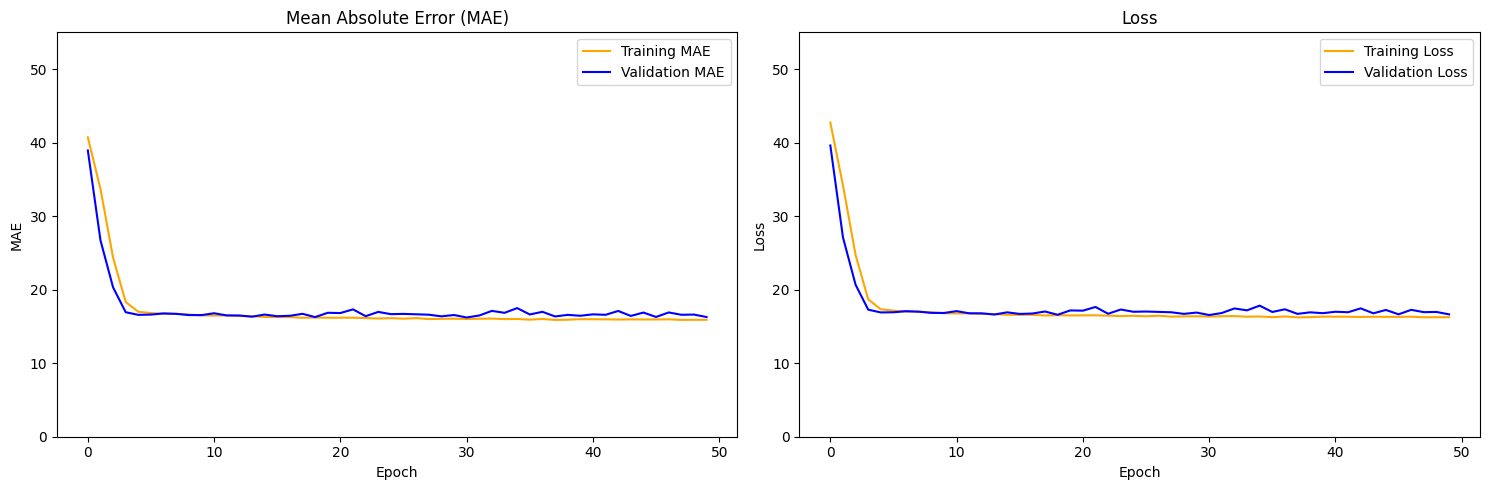

r2: 0.14473452024967381


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

This is the best one so far!!

<Figure size 1800x1400 with 0 Axes>

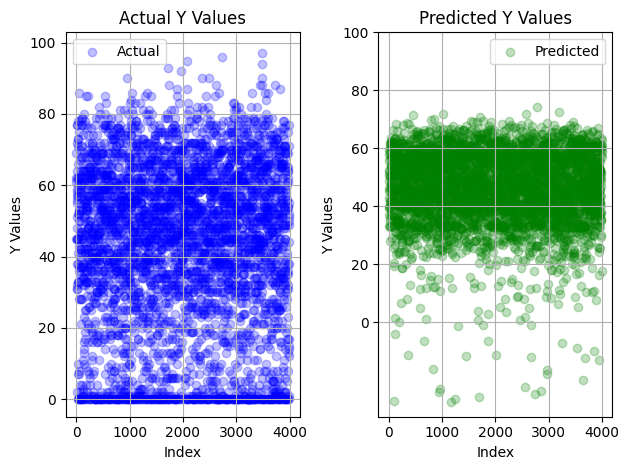

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

This one is the best so far! Let's try adding a few more layers.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model11 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model11.add(layers.Dense(59, activation="relu", kernel_regularizer=regularizer))
model11.add(layers.BatchNormalization()) #new
model11.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizer)) # new
model11.add(layers.BatchNormalization())
model11.add(layers.Dense(40, activation="relu", kernel_regularizer=regularizer)) # this was 29
model11.add(layers.BatchNormalization()) # new
model11.add(layers.Dense(30, activation="relu", kernel_regularizer=regularizer)) # this was 14
model11.add(layers.BatchNormalization())
model11.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer)) # this was 7
model11.add(layers.BatchNormalization())
model11.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizer)) # new
model11.add(layers.BatchNormalization())


# Declare the output layer
# Single node output as this is regression
model11.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model11.compile(optimizer=tf.keras.optimizers.Adam(), # back to default learning rate
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model11.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model11.predict(X_test)

Epoch 1/50
500/500 [==============================] - 9s 7ms/step - loss: 44.4858 - mean_absolute_error: 40.4225 - val_loss: 38.7159 - val_mean_absolute_error: 37.1309
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 32.6206 - mean_absolute_error: 31.4606 - val_loss: 25.3602 - val_mean_absolute_error: 24.4495
Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 21.8661 - mean_absolute_error: 21.0757 - val_loss: 18.6124 - val_mean_absolute_error: 17.9292
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 17.9066 - mean_absolute_error: 17.2916 - val_loss: 17.5281 - val_mean_absolute_error: 16.9684
Epoch 5/50
500/500 [==============================] - 2s 4ms/step - loss: 17.5277 - mean_absolute_error: 17.0086 - val_loss: 17.1283 - val_mean_absolute_error: 16.6478
Epoch 6/50
500/500 [==============================] - 2s 5ms/step - loss: 17.3091 - mean_absolute_error: 16.8453 - val_loss: 17.4753 - val_mean_absolute_error: 

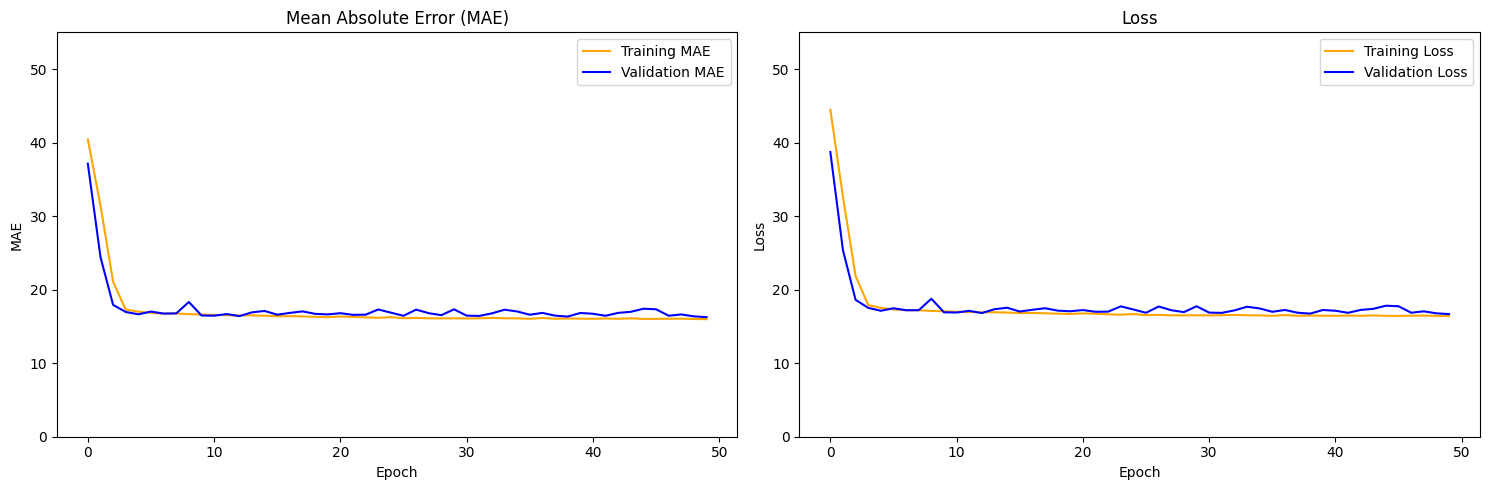

r2: 0.1416181954770499


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

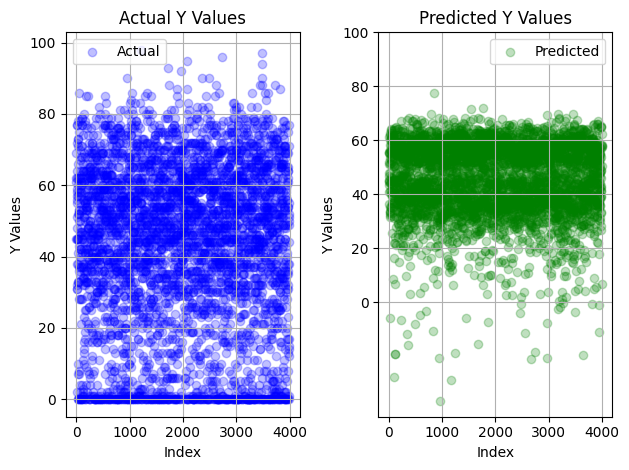

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

MAE is similar and r2 is a lower. Let's go back to coefficients and decrease the feature number even more.

## Part 3: Modeling with top 30 features

In [ ]:
coef_df_sorted.head(10) # top ten with highest positive coefficients

Feature  Coefficients    Odds Ratio
2                          Memorable     19.376492  2.600779e+08
12                      danceability     12.536034  2.781829e+05
43  playlist_subgenre_permanent wave      7.130845  1.249932e+03
67                   lang_Portuguese      7.044396  1.146416e+03
45   playlist_subgenre_post-teen pop      6.100081  4.458941e+02
1                          Relatable      5.654786  2.856554e+02
36         playlist_subgenre_hip hop      5.535181  2.534536e+02
22                 album_decade_1970      5.052155  1.563591e+02
21                 album_decade_1960      4.639811  1.035248e+02
23                 album_decade_1980      4.232587  6.889521e+01

In [ ]:
coef_df_sorted.tail(10) # top ten with highest negative coefficients

Feature  Coefficients    Odds Ratio
4                                      Symbolic     -9.217487  9.928793e-05
32              playlist_subgenre_electro house    -10.329540  3.265410e-05
39              playlist_subgenre_latin hip hop    -11.638602  8.819001e-06
47           playlist_subgenre_southern hip hop    -11.865075  7.031747e-06
44                    playlist_subgenre_pop edm    -13.240925  1.776395e-06
34               playlist_subgenre_gangster rap    -13.792394  1.023386e-06
41                   playlist_subgenre_neo soul    -15.193445  2.520987e-07
29                   playlist_subgenre_big room    -16.086547  1.032052e-07
42             playlist_subgenre_new jack swing    -19.694599  2.797335e-09
46  playlist_subgenre_progressive electro house    -20.611243  1.118538e-09

In [ ]:
# let's do this by the absolute value of the coefficient
coef_df['Absolute_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Absolute_Coefficients', ascending=False).head(30) # create a dataframe with the top 30
sorted_coef_df

Feature  Coefficients    Odds Ratio  \
46  playlist_subgenre_progressive electro house    -20.611243  1.118538e-09   
42             playlist_subgenre_new jack swing    -19.694599  2.797335e-09   
2                                     Memorable     19.376492  2.600779e+08   
29                   playlist_subgenre_big room    -16.086547  1.032052e-07   
41                   playlist_subgenre_neo soul    -15.193445  2.520987e-07   
34               playlist_subgenre_gangster rap    -13.792394  1.023386e-06   
44                    playlist_subgenre_pop edm    -13.240925  1.776395e-06   
12                                 danceability     12.536034  2.781829e+05   
47           playlist_subgenre_southern hip hop    -11.865075  7.031747e-06   
39              playlist_subgenre_latin hip hop    -11.638602  8.819001e-06   
32              playlist_subgenre_electro house    -10.329540  3.265410e-05   
4                                      Symbolic     -9.217487  9.928793e-05   
17                                  duration_ms     -9.206798  1.003548e-04   
25                            album_decade_2000     -8.030592  3.253555e-04   
35                  playlist_subgenre_hard rock     -7.786691  4.152248e-04   
30               playlist_subgenre_classic rock     -7.672586  4.654127e-04   
49                   playlist_subgenre_tropical     -7.459449  5.759734e-04   
28                 playlist_subgenre_album rock     -7.346006  6.451637e-04   
43             playlist_subgenre_permanent wave      7.130845  1.249932e+03   
67                              lang_Portuguese      7.044396  1.146416e+03   
33                 playlist_subgenre_electropop     -6.923630  9.842508e-04   
38            playlist_subgenre_indie poptimism     -6.595700  1.366230e-03   
45              playlist_subgenre_post-teen pop      6.100081  4.458941e+02   
15                                      valence     -6.045511  2.368471e-03   
1                                     Relatable      5.654786  2.856554e+02   
36                    playlist_subgenre_hip hop      5.535181  2.534536e+02   
22                            album_decade_1970      5.052155  1.563591e+02   
21                            album_decade_1960      4.639811  1.035248e+02   
23                            album_decade_1980      4.232587  6.889521e+01   
37                    playlist_subgenre_hip pop     -3.668513  2.551438e-02   

    Absolute_Coefficients  
46              20.611243  
42              19.694599  
2               19.376492  
29              16.086547  
41              15.193445  
34              13.792394  
44              13.240925  
12              12.536034  
47              11.865075  
39              11.638602  
32              10.329540  
4                9.217487  
17               9.206798  
25               8.030592  
35               7.786691  
30               7.672586  
49               7.459449  
28               7.346006  
43               7.130845  
67               7.044396  
33               6.923630  
38               6.595700  
45               6.100081  
15               6.045511  
1                5.654786  
36               5.535181  
22               5.052155  
21               4.639811  
23               4.232587  
37               3.668513

In [ ]:
cols = sorted_coef_df['Feature'].tolist()
cols

['playlist_subgenre_progressive electro house',
 'playlist_subgenre_new jack swing',
 'Memorable',
 'playlist_subgenre_big room',
 'playlist_subgenre_neo soul',
 'playlist_subgenre_gangster rap',
 'playlist_subgenre_pop edm',
 'danceability',
 'playlist_subgenre_southern hip hop',
 'playlist_subgenre_latin hip hop',
 'playlist_subgenre_electro house',
 'Symbolic',
 'duration_ms',
 'album_decade_2000',
 'playlist_subgenre_hard rock',
 'playlist_subgenre_classic rock',
 'playlist_subgenre_tropical',
 'playlist_subgenre_album rock',
 'playlist_subgenre_permanent wave',
 'lang_Portuguese',
 'playlist_subgenre_electropop',
 'playlist_subgenre_indie poptimism',
 'playlist_subgenre_post-teen pop',
 'valence',
 'Relatable',
 'playlist_subgenre_hip hop',
 'album_decade_1970',
 'album_decade_1960',
 'album_decade_1980',
 'playlist_subgenre_hip pop']

In [ ]:
X_train = X_train[cols]
X_train.head()

playlist_subgenre_progressive electro house  \
track_id                                                              
0WEgOlUCB9nHPsoD8Ae4Zz                                            0   
1KjQPDJQCUuqDj3AmfSBCa                                            0   
0taOCiup4HNG9LmbduVlJj                                            0   
7a9QBLlQOunA6KvPcVDIMt                                            0   
69QIVIjPMnI1ABLBqh9P1b                                            0   

                        playlist_subgenre_new jack swing  Memorable  \
track_id                                                              
0WEgOlUCB9nHPsoD8Ae4Zz                                 0   0.777778   
1KjQPDJQCUuqDj3AmfSBCa                                 0   0.555556   
0taOCiup4HNG9LmbduVlJj                                 0   0.555556   
7a9QBLlQOunA6KvPcVDIMt                                 0   0.777778   
69QIVIjPMnI1ABLBqh9P1b                                 0   0.777778   

                        playlist_subgenre_big room  \
track_id                                             
0WEgOlUCB9nHPsoD8Ae4Zz                           0   
1KjQPDJQCUuqDj3AmfSBCa                           0   
0taOCiup4HNG9LmbduVlJj                           0   
7a9QBLlQOunA6KvPcVDIMt                           0   
69QIVIjPMnI1ABLBqh9P1b                           0   

                        playlist_subgenre_neo soul  \
track_id                                             
0WEgOlUCB9nHPsoD8Ae4Zz                           0   
1KjQPDJQCUuqDj3AmfSBCa                           0   
0taOCiup4HNG9LmbduVlJj                           0   
7a9QBLlQOunA6KvPcVDIMt                           0   
69QIVIjPMnI1ABLBqh9P1b                           0   

                        playlist_subgenre_gangster rap  \
track_id                                                 
0WEgOlUCB9nHPsoD8Ae4Zz                               0   
1KjQPDJQCUuqDj3AmfSBCa                               1   
0taOCiup4HNG9LmbduVlJj                               0   
7a9QBLlQOunA6KvPcVDIMt                               1   
69QIVIjPMnI1ABLBqh9P1b                               0   

                        playlist_subgenre_pop edm  danceability  \
track_id                                                          
0WEgOlUCB9nHPsoD8Ae4Zz                          0      0.368584   
1KjQPDJQCUuqDj3AmfSBCa                          0      0.595982   
0taOCiup4HNG9LmbduVlJj                          0      0.710785   
7a9QBLlQOunA6KvPcVDIMt                          0      0.836627   
69QIVIjPMnI1ABLBqh9P1b                          0      0.593774   

                        playlist_subgenre_southern hip hop  \
track_id                                                     
0WEgOlUCB9nHPsoD8Ae4Zz                                   0   
1KjQPDJQCUuqDj3AmfSBCa                                   0   
0taOCiup4HNG9LmbduVlJj                                   0   
7a9QBLlQOunA6KvPcVDIMt                                   0   
69QIVIjPMnI1ABLBqh9P1b                                   0   

                        playlist_subgenre_latin hip hop  \
track_id                                                  
0WEgOlUCB9nHPsoD8Ae4Zz                                0   
1KjQPDJQCUuqDj3AmfSBCa                                0   
0taOCiup4HNG9LmbduVlJj                                0   
7a9QBLlQOunA6KvPcVDIMt                                0   
69QIVIjPMnI1ABLBqh9P1b                                0   

                        playlist_subgenre_electro house  Symbolic  \
track_id                                                            
0WEgOlUCB9nHPsoD8Ae4Zz                                0  0.666667   
1KjQPDJQCUuqDj3AmfSBCa                                0  0.222222   
0taOCiup4HNG9LmbduVlJj                                0  0.222222   
7a9QBLlQOunA6KvPcVDIMt                                0  0.444444   
69QIVIjPMnI1ABLBqh9P1b                                0  0.444444   

                        duration_ms  album_decade_2000  \
tr

In [ ]:
X_test = X_test[cols]
X_test.head()

playlist_subgenre_progressive electro house  \
track_id                                                              
31dqpLUModJWNbxrXu6TWd                                            0   
47yCngqUUSQVpw0U4S2yeO                                            0   
7zzZmpw8L66ZPjH1M6qmOs                                            0   
1F9xcExF9W7m5BxTdlJLED                                            0   
2ZWlPOoWh0626oTaHrnl2a                                            0   

                        playlist_subgenre_new jack swing  Memorable  \
track_id                                                              
31dqpLUModJWNbxrXu6TWd                                 0   0.777778   
47yCngqUUSQVpw0U4S2yeO                                 0   0.000000   
7zzZmpw8L66ZPjH1M6qmOs                                 0   0.777778   
1F9xcExF9W7m5BxTdlJLED                                 0   0.888889   
2ZWlPOoWh0626oTaHrnl2a                                 0   0.888889   

                        playlist_subgenre_big room  \
track_id                                             
31dqpLUModJWNbxrXu6TWd                           0   
47yCngqUUSQVpw0U4S2yeO                           0   
7zzZmpw8L66ZPjH1M6qmOs                           0   
1F9xcExF9W7m5BxTdlJLED                           1   
2ZWlPOoWh0626oTaHrnl2a                           0   

                        playlist_subgenre_neo soul  \
track_id                                             
31dqpLUModJWNbxrXu6TWd                           0   
47yCngqUUSQVpw0U4S2yeO                           0   
7zzZmpw8L66ZPjH1M6qmOs                           0   
1F9xcExF9W7m5BxTdlJLED                           0   
2ZWlPOoWh0626oTaHrnl2a                           0   

                        playlist_subgenre_gangster rap  \
track_id                                                 
31dqpLUModJWNbxrXu6TWd                               0   
47yCngqUUSQVpw0U4S2yeO                               0   
7zzZmpw8L66ZPjH1M6qmOs                               0   
1F9xcExF9W7m5BxTdlJLED                               0   
2ZWlPOoWh0626oTaHrnl2a                               0   

                        playlist_subgenre_pop edm  danceability  \
track_id                                                          
31dqpLUModJWNbxrXu6TWd                          0      0.556242   
47yCngqUUSQVpw0U4S2yeO                          0      0.747213   
7zzZmpw8L66ZPjH1M6qmOs                          0      0.647864   
1F9xcExF9W7m5BxTdlJLED                          0      0.269235   
2ZWlPOoWh0626oTaHrnl2a                          0      0.540788   

                        playlist_subgenre_southern hip hop  \
track_id                                                     
31dqpLUModJWNbxrXu6TWd                                   0   
47yCngqUUSQVpw0U4S2yeO                                   0   
7zzZmpw8L66ZPjH1M6qmOs                                   0   
1F9xcExF9W7m5BxTdlJLED                                   0   
2ZWlPOoWh0626oTaHrnl2a                                   0   

                        playlist_subgenre_latin hip hop  \
track_id                                                  
31dqpLUModJWNbxrXu6TWd                                0   
47yCngqUUSQVpw0U4S2yeO                                0   
7zzZmpw8L66ZPjH1M6qmOs                                0   
1F9xcExF9W7m5BxTdlJLED                                0   
2ZWlPOoWh0626oTaHrnl2a                                0   

                        playlist_subgenre_electro house  Symbolic  \
track_id                                                            
31dqpLUModJWNbxrXu6TWd                                0  0.555556   
47yCngqUUSQVpw0U4S2yeO                                0  0.000000   
7zzZmpw8L66ZPjH1M6qmOs                                0  0.555556   
1F9xcExF9W7m5BxTdlJLED                                0  0.000000   
2ZWlPOoWh0626oTaHrnl2a                                0  0.666667   

                        duration_ms  album_decade_2000  \
tr

In [ ]:
X_train.shape, X_test.shape # we now have 30 features

((15980, 30), (3995, 30))

Let's build some neural nets!

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model12 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers numbers changed from Model11
model12.add(layers.Dense(30, activation="relu", kernel_regularizer=regularizer))
model12.add(layers.BatchNormalization())
model12.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer))
model12.add(layers.BatchNormalization())
model12.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizer))
model12.add(layers.BatchNormalization())
model12.add(layers.Dense(5, activation="relu", kernel_regularizer=regularizer))
model12.add(layers.BatchNormalization())



# Declare the output layer
# Single node output as this is regression
model12.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model12.compile(optimizer=tf.keras.optimizers.Adam(), # back to default learning rate
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model12.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model12.predict(X_test)

Epoch 1/50
500/500 [==============================] - 4s 3ms/step - loss: 42.3958 - mean_absolute_error: 40.9254 - val_loss: 40.4841 - val_mean_absolute_error: 39.8479
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 35.9498 - mean_absolute_error: 35.4659 - val_loss: 30.0897 - val_mean_absolute_error: 29.7000
Epoch 3/50
500/500 [==============================] - 2s 5ms/step - loss: 27.9198 - mean_absolute_error: 27.5684 - val_loss: 24.1872 - val_mean_absolute_error: 23.8561
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 21.0813 - mean_absolute_error: 20.7611 - val_loss: 18.1620 - val_mean_absolute_error: 17.8543
Epoch 5/50
500/500 [==============================] - 2s 3ms/step - loss: 18.0014 - mean_absolute_error: 17.7028 - val_loss: 17.2914 - val_mean_absolute_error: 17.0006
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 17.4253 - mean_absolute_error: 17.1406 - val_loss: 17.1539 - val_mean_absolute_error: 

In [ ]:
model12.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 30)                930       
                                                                 
 batch_normalization_36 (Ba  (None, 30)                120       
 tchNormalization)                                               
                                                                 
 dense_79 (Dense)            (None, 20)                620       
                                                                 
 batch_normalization_37 (Ba  (None, 20)                80        
 tchNormalization)                                               
                                                                 
 dense_80 (Dense)            (None, 10)                210       
                                                                 
 batch_normalization_38 (Ba  (None, 10)              

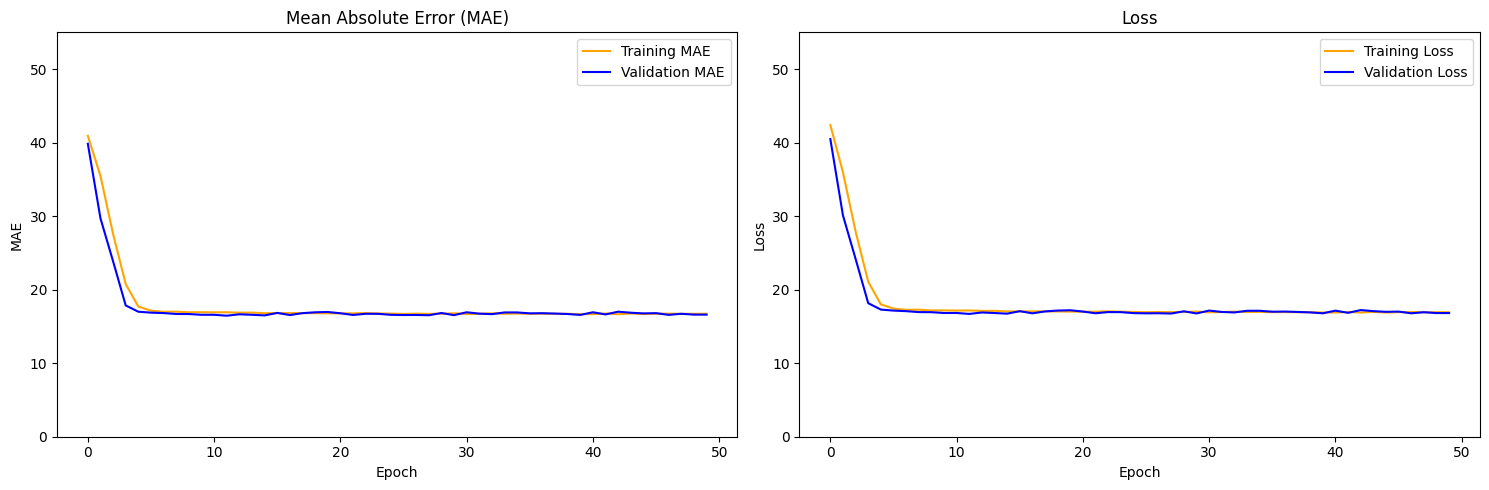

r2: 0.14628116272514868


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

125/125 [==============================] - 0s 3ms/step


<Figure size 1800x1400 with 0 Axes>

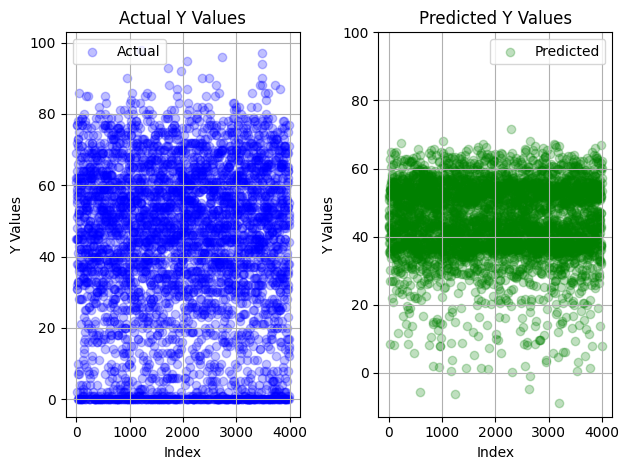

In [ ]:
y_pred = model12.predict(X_test)
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

This is a good beginning but not better than the best model with 59 features (model10 with mae: 16.2, r2: 0.16) which is the best model so far. Let's simplify the structure a little.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model13 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model13.add(layers.Dense(30, activation="relu", kernel_regularizer=regularizer))
model13.add(layers.BatchNormalization())
model13.add(layers.Dense(15, activation="relu", kernel_regularizer=regularizer)) # this was 20
model13.add(layers.BatchNormalization())
model13.add(layers.Dense(7, activation="relu", kernel_regularizer=regularizer)) # this was 10 and there were 2 more layers
model13.add(layers.BatchNormalization())

# Declare the output layer
# Single node output as this is regression
model13.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model13.compile(optimizer=tf.keras.optimizers.Adam(), # back to default learning rate
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model13.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model13.predict(X_test)

Epoch 1/50
500/500 [==============================] - 7s 5ms/step - loss: 41.6956 - mean_absolute_error: 40.4432 - val_loss: 38.9862 - val_mean_absolute_error: 38.3497
Epoch 2/50
500/500 [==============================] - 2s 3ms/step - loss: 33.7520 - mean_absolute_error: 33.2449 - val_loss: 26.9788 - val_mean_absolute_error: 26.5502
Epoch 3/50
500/500 [==============================] - 1s 3ms/step - loss: 24.4343 - mean_absolute_error: 24.0400 - val_loss: 19.7905 - val_mean_absolute_error: 19.4195
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 18.6566 - mean_absolute_error: 18.3064 - val_loss: 17.0598 - val_mean_absolute_error: 16.7248
Epoch 5/50
500/500 [==============================] - 1s 3ms/step - loss: 17.4361 - mean_absolute_error: 17.1117 - val_loss: 17.1631 - val_mean_absolute_error: 16.8519
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 17.2529 - mean_absolute_error: 16.9515 - val_loss: 17.1738 - val_mean_absolute_error: 

In [ ]:
model13.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 30)                930       
                                                                 
 batch_normalization_40 (Ba  (None, 30)                120       
 tchNormalization)                                               
                                                                 
 dense_84 (Dense)            (None, 15)                465       
                                                                 
 batch_normalization_41 (Ba  (None, 15)                60        
 tchNormalization)                                               
                                                                 
 dense_85 (Dense)            (None, 7)                 112       
                                                                 
 batch_normalization_42 (Ba  (None, 7)               

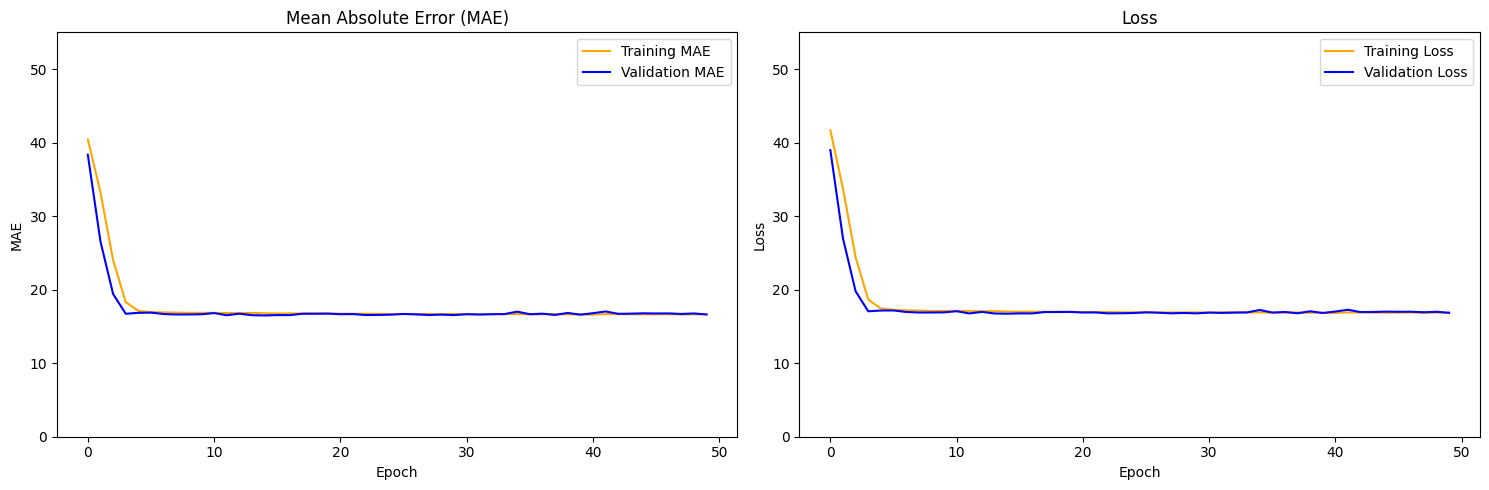

r2: 0.10174675720295234


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

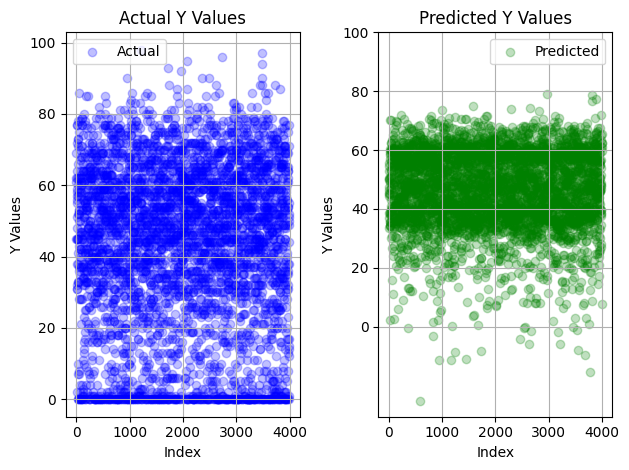

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

This model has a lower r2 than the last one. Let's try with top 15 features.

## Part 4: Modeling with top 15 features

In [ ]:
top_fifteen = sorted_coef_df.head(15) # get the top 15 features

cols = top_fifteen['Feature'].tolist() # save to a list

cols

['playlist_subgenre_progressive electro house',
 'playlist_subgenre_new jack swing',
 'Memorable',
 'playlist_subgenre_big room',
 'playlist_subgenre_neo soul',
 'playlist_subgenre_gangster rap',
 'playlist_subgenre_pop edm',
 'danceability',
 'playlist_subgenre_southern hip hop',
 'playlist_subgenre_latin hip hop',
 'playlist_subgenre_electro house',
 'Symbolic',
 'duration_ms',
 'album_decade_2000',
 'playlist_subgenre_hard rock']

In [ ]:
X_train = X_train[cols]
X_train.shape

(15980, 15)

In [ ]:
X_test = X_test[cols]
X_test.shape

(3995, 15)

Let's try Model12 with this data.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model12b = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model12b.add(layers.Dense(30, activation="relu", kernel_regularizer=regularizer))
model12b.add(layers.BatchNormalization())
model12b.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer))
model12b.add(layers.BatchNormalization())
model12b.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizer))
model12b.add(layers.BatchNormalization())
model12b.add(layers.Dense(5, activation="relu", kernel_regularizer=regularizer))
model12b.add(layers.BatchNormalization())



# Declare the output layer
# Single node output as this is regression
model12b.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model12b.compile(optimizer=tf.keras.optimizers.Adam(), # back to default learning rate
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model12b.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model12b.predict(X_test)

Epoch 1/50
500/500 [==============================] - 6s 5ms/step - loss: 42.2832 - mean_absolute_error: 41.1375 - val_loss: 40.5429 - val_mean_absolute_error: 40.1665
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 36.2201 - mean_absolute_error: 35.9669 - val_loss: 31.5359 - val_mean_absolute_error: 31.3523
Epoch 3/50
500/500 [==============================] - 3s 5ms/step - loss: 28.3946 - mean_absolute_error: 28.2309 - val_loss: 22.6672 - val_mean_absolute_error: 22.5170
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 21.5640 - mean_absolute_error: 21.4224 - val_loss: 18.6028 - val_mean_absolute_error: 18.4663
Epoch 5/50
500/500 [==============================] - 2s 3ms/step - loss: 18.3729 - mean_absolute_error: 18.2367 - val_loss: 17.9451 - val_mean_absolute_error: 17.8096
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 17.7809 - mean_absolute_error: 17.6509 - val_loss: 17.3928 - val_mean_absolute_error: 

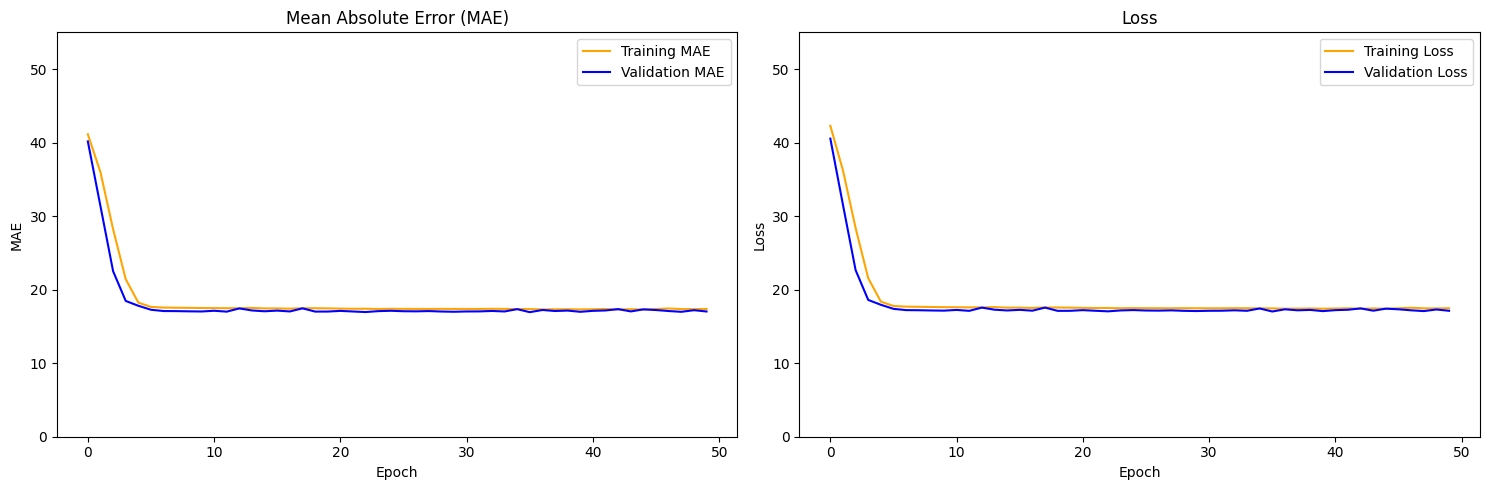

r2: 0.12000023026078421


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

MAE is 17 and r2 is 0.12. This is not better than Model12 (MAE: 16.6, r2: 0.14) or the best model so far, Model 10 (MAE: 16.2, r2: 0.16).

## Part 5: Modeling with PCA (0.9)

First let's load the original test and train data.

In [ ]:
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/X_train.csv', index_col=0)
y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/y_train.csv',index_col=0)
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/X_test.csv', index_col=0)
y_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/y_test.csv', index_col=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape # check shapes

((15980, 69), (3995, 69), (15980, 1), (3995, 1))

In [ ]:
X_train.head() # looks good

Clear  Relatable  Memorable  Engaging  Symbolic  \
track_id                                                                     
0WEgOlUCB9nHPsoD8Ae4Zz  0.888889      0.625   0.777778     0.875  0.666667   
1KjQPDJQCUuqDj3AmfSBCa  0.444444      0.125   0.555556     0.500  0.222222   
0taOCiup4HNG9LmbduVlJj  0.444444      0.250   0.555556     0.375  0.222222   
7a9QBLlQOunA6KvPcVDIMt  0.666667      0.500   0.777778     0.625  0.444444   
69QIVIjPMnI1ABLBqh9P1b  0.777778      0.625   0.777778     0.750  0.444444   

                         Lyrical     Happy  Surprised  Fearful     Angry  \
track_id                                                                   
0WEgOlUCB9nHPsoD8Ae4Zz  0.777778  0.444444      0.625    0.250  0.222222   
1KjQPDJQCUuqDj3AmfSBCa  0.444444  0.111111      0.000    0.875  0.000000   
0taOCiup4HNG9LmbduVlJj  0.555556  0.111111      0.125    0.875  0.777778   
7a9QBLlQOunA6KvPcVDIMt  0.666667  0.333333      0.625    0.125  0.111111   
69QIVIjPMnI1ABLBqh9P1b  0.777778  0.555556      0.375    0.500  0.333333   

                        Disgusted    Sad  danceability  loudness  mode  \
track_id                                                                 
0WEgOlUCB9nHPsoD8Ae4Zz      0.375  0.750      0.368584  1.282079     0   
1KjQPDJQCUuqDj3AmfSBCa      0.000  0.125      0.595982  0.896323     1   
0taOCiup4HNG9LmbduVlJj      0.875  0.375      0.710785 -0.843307     1   
7a9QBLlQOunA6KvPcVDIMt      0.250  0.375      0.836627 -0.750427     0   
69QIVIjPMnI1ABLBqh9P1b      0.375  0.500      0.593774 -1.000931     1   

                         valence     tempo  duration_ms  \
track_id                                                  
0WEgOlUCB9nHPsoD8Ae4Zz  0.150496  0.780007     0.324599   
1KjQPDJQCUuqDj3AmfSBCa  0.599996  0.643504     0.333200   
0taOCiup4HNG9LmbduVlJj  0.516157  0.387052     0.259184   
7a9QBLlQOunA6KvPcVDIMt  0.172719  0.452517     0.493096   
69QIVIjPMnI1ABLBqh9P1b  0.830301  0.757543     0.473410   

                        album_release_quarter_1  album_release_quarter_3  \
track_id                                                                   
0WEgOlUCB9nHPsoD8Ae4Zz                        0                        0   
1KjQPDJQCUuqDj3AmfSBCa                        1                        0   
0taOCiup4HNG9LmbduVlJj                        0                        0   
7a9QBLlQOunA6KvPcVDIMt                        0                        1   
69QIVIjPMnI1ABLBqh9P1b                        1                        0   

                        album_release_quarter_4  album_decade_1960  \
track_id                                                             
0WEgOlUCB9nHPsoD8Ae4Zz                        1                  0   
1KjQPDJQCUuqDj3AmfSBCa                        0                  0   
0taOCiup4HNG9LmbduVlJj                        1                  0   
7a9QBLlQOunA6KvPcVDIMt                        0                  0   
69QIVIjPMnI1ABLBqh9P1b                        0                  0   

                        album_decade_1970  album_decade_1980  \
track_id                                                       
0WEgOlUCB9nHPsoD8Ae4Zz                  0                  0   
1KjQPDJQCUuqDj3AmfSBCa                  0                  0   
0taOCiup4HNG9LmbduVlJj                  0                  0   
7a9QBLlQOunA6KvPcVDIMt                  0                  0   
69QIVIjPMnI1ABLBqh9P1b                  0                  0   

                        album_decade_1990  album_decade_2000  \
track_id                                                       
0WEgOlUCB9nHPsoD8Ae4Zz                  0                  0   
1KjQPDJQCUuqDj3AmfSBCa                  0                  0   
0taOCiup4HNG9LmbduVlJj                  0                  0   
7a9QBLlQOunA6KvPcVDIMt                  0                  0   
69QIVIjPMnI1ABLBqh9P1b                  1                  0   

                        album_decade_2010  album_decade_2020  \
track_id                    

In [ ]:
X_test.head() # looks good

Clear  Relatable  Memorable  Engaging  Symbolic  \
track_id                                                                     
31dqpLUModJWNbxrXu6TWd  0.777778      0.625   0.777778     0.750  0.555556   
47yCngqUUSQVpw0U4S2yeO  0.111111      0.000   0.000000     0.125  0.000000   
7zzZmpw8L66ZPjH1M6qmOs  0.777778      0.875   0.777778     0.750  0.555556   
1F9xcExF9W7m5BxTdlJLED  0.888889      0.000   0.888889     0.125  0.000000   
2ZWlPOoWh0626oTaHrnl2a  0.888889      0.875   0.888889     0.875  0.666667   

                         Lyrical     Happy  Surprised  Fearful     Angry  \
track_id                                                                   
31dqpLUModJWNbxrXu6TWd  0.777778  0.333333       0.25    0.500  0.333333   
47yCngqUUSQVpw0U4S2yeO  0.111111  0.000000       0.00    0.000  0.000000   
7zzZmpw8L66ZPjH1M6qmOs  0.777778  0.222222       0.75    0.375  0.333333   
1F9xcExF9W7m5BxTdlJLED  0.888889  0.555556       0.00    0.000  0.000000   
2ZWlPOoWh0626oTaHrnl2a  0.888889  0.555556       0.50    0.375  0.333333   

                        Disgusted    Sad  danceability  loudness  mode  \
track_id                                                                 
31dqpLUModJWNbxrXu6TWd      0.375  0.625      0.556242 -0.154506     1   
47yCngqUUSQVpw0U4S2yeO      0.000  0.000      0.747213 -1.130759     0   
7zzZmpw8L66ZPjH1M6qmOs      0.625  0.875      0.647864  0.273283     1   
1F9xcExF9W7m5BxTdlJLED      0.000  0.000      0.269235  0.659717     0   
2ZWlPOoWh0626oTaHrnl2a      0.625  0.875      0.540788 -0.939916     0   

                         valence     tempo  duration_ms  \
track_id                                                  
31dqpLUModJWNbxrXu6TWd  0.625249  0.473812     0.464452   
47yCngqUUSQVpw0U4S2yeO  0.237366  0.239754     0.431197   
7zzZmpw8L66ZPjH1M6qmOs  0.223224  0.425553     0.488345   
1F9xcExF9W7m5BxTdlJLED  0.180800  0.517746     0.337420   
2ZWlPOoWh0626oTaHrnl2a  0.456560  0.432723     0.449909   

                        album_release_quarter_1  album_release_quarter_3  \
track_id                                                                   
31dqpLUModJWNbxrXu6TWd                        1                        0   
47yCngqUUSQVpw0U4S2yeO                        0                        0   
7zzZmpw8L66ZPjH1M6qmOs                        0                        1   
1F9xcExF9W7m5BxTdlJLED                        1                        0   
2ZWlPOoWh0626oTaHrnl2a                        0                        1   

                        album_release_quarter_4  album_decade_1960  \
track_id                                                             
31dqpLUModJWNbxrXu6TWd                        0                  0   
47yCngqUUSQVpw0U4S2yeO                        1                  0   
7zzZmpw8L66ZPjH1M6qmOs                        0                  0   
1F9xcExF9W7m5BxTdlJLED                        0                  0   
2ZWlPOoWh0626oTaHrnl2a                        0                  0   

                        album_decade_1970  album_decade_1980  \
track_id                                                       
31dqpLUModJWNbxrXu6TWd                  0                  1   
47yCngqUUSQVpw0U4S2yeO                  0                  0   
7zzZmpw8L66ZPjH1M6qmOs                  0                  0   
1F9xcExF9W7m5BxTdlJLED                  0                  0   
2ZWlPOoWh0626oTaHrnl2a                  0                  0   

                        album_decade_1990  album_decade_2000  \
track_id                                                       
31dqpLUModJWNbxrXu6TWd                  0                  0   
47yCngqUUSQVpw0U4S2yeO                  0                  0   
7zzZmpw8L66ZPjH1M6qmOs                  0                  1   
1F9xcExF9W7m5BxTdlJLED                  0                  0   
2ZWlPOoWh0626oTaHrnl2a                  0                  0   

                        album_decade_2010  album_decade_2020  \
track_id                    

In [ ]:
y_train = y_train['track_popularity'] # change it back to an array
y_train.shape # the shape is now correct

(15980,)

In [ ]:
y_test = y_test['track_popularity'] # change it back to an array
y_test.shape # the shape is now correct

(3995,)

Let's explore PCA options with different n_components.

In [ ]:
# instantiate and fit the PCA
my_PCA = PCA()
my_PCA.fit(X_train)

# transform data
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)

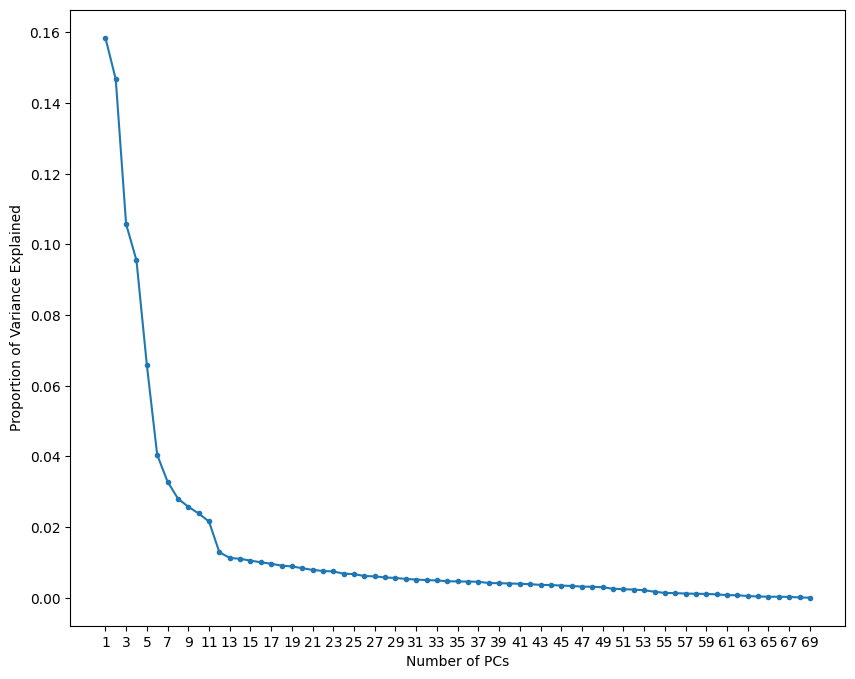

In [ ]:
# store the explained variance ratio attribute
expl_var = my_PCA.explained_variance_ratio_

# make a plot
plt.figure(figsize=(10,8))
plt.plot(range(1,70),expl_var,marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,70,2))
plt.show()

In [ ]:
# Pull out the explained variance ratio
expl_var = my_PCA.explained_variance_ratio_

# Calculate the cumulative sum of this array using the
cumulative_sum = np.cumsum(expl_var)

cumulative_sum

array([0.15851663, 0.30531634, 0.41108786, 0.50657811, 0.57253952,
       0.61299028, 0.64586274, 0.67393737, 0.69969451, 0.72355364,
       0.74513389, 0.75802746, 0.76929304, 0.78031554, 0.79081337,
       0.80085003, 0.81047427, 0.81955915, 0.82841642, 0.83677518,
       0.84465399, 0.85223411, 0.85967596, 0.86647773, 0.8731632 ,
       0.87930822, 0.88536066, 0.89109842, 0.89669169, 0.90201224,
       0.90715686, 0.91214846, 0.91704471, 0.92171168, 0.92632273,
       0.93089135, 0.93541828, 0.9395785 , 0.94370633, 0.94773158,
       0.95168389, 0.95552623, 0.95915616, 0.96275805, 0.96620263,
       0.96953127, 0.97268237, 0.9757771 , 0.9787498 , 0.98128952,
       0.98369969, 0.98600122, 0.98811798, 0.98983029, 0.99119519,
       0.99249871, 0.99368429, 0.99480791, 0.99588254, 0.99684035,
       0.99757491, 0.99827976, 0.99875779, 0.99911031, 0.99939757,
       0.99967131, 0.99990851, 0.99999706, 1.        ])

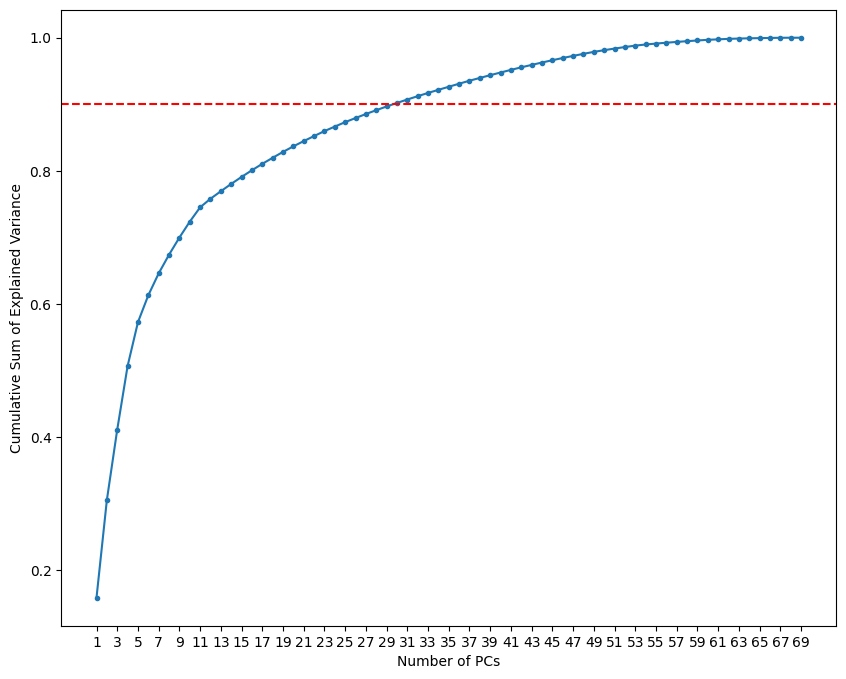

In [ ]:
# Plot out the cumulative sum graph

plt.figure(figsize=(10,8))
plt.plot(range(1,70), cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(1,70,2))
plt.show()

Let's choose 0.9 cumulative sum of explained variance.

In [ ]:
# Instantiate and fit
my_PCA = PCA(n_components = 0.9)
my_PCA.fit(X_train)

# Transform train and test
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)

In [ ]:
print(f'Original: {X_train.shape}')
print(f'PCA Transformed: {X_train_PCA.shape}')

Original: (15980, 69)
PCA Transformed: (15980, 30)


Let's build a neural net.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model13 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model13.add(layers.Dense(30, activation="relu", kernel_regularizer=regularizer))
model13.add(layers.BatchNormalization())
model13.add(layers.Dense(15, activation="relu", kernel_regularizer=regularizer))
model13.add(layers.BatchNormalization())
model13.add(layers.Dense(7, activation="relu", kernel_regularizer=regularizer))
model13.add(layers.BatchNormalization())


# Declare the output layer
# Single node output as this is regression
model13.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model13.compile(optimizer=tf.keras.optimizers.Adam(), # back to default learning rate
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model13.fit(X_train_PCA, y_train, epochs=50, verbose=1, validation_data=(X_test_PCA, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model13.predict(X_test_PCA)

Epoch 1/50
500/500 [==============================] - 3s 3ms/step - loss: 41.9626 - mean_absolute_error: 40.8372 - val_loss: 39.9569 - val_mean_absolute_error: 39.5034
Epoch 2/50
500/500 [==============================] - 1s 3ms/step - loss: 34.7554 - mean_absolute_error: 34.3942 - val_loss: 29.6007 - val_mean_absolute_error: 29.2818
Epoch 3/50
500/500 [==============================] - 1s 3ms/step - loss: 25.5786 - mean_absolute_error: 25.2668 - val_loss: 21.7574 - val_mean_absolute_error: 21.4478
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 19.5564 - mean_absolute_error: 19.2449 - val_loss: 18.1929 - val_mean_absolute_error: 17.8871
Epoch 5/50
500/500 [==============================] - 2s 4ms/step - loss: 18.1422 - mean_absolute_error: 17.8365 - val_loss: 17.8875 - val_mean_absolute_error: 17.5837
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 17.9271 - mean_absolute_error: 17.6239 - val_loss: 17.8707 - val_mean_absolute_error: 

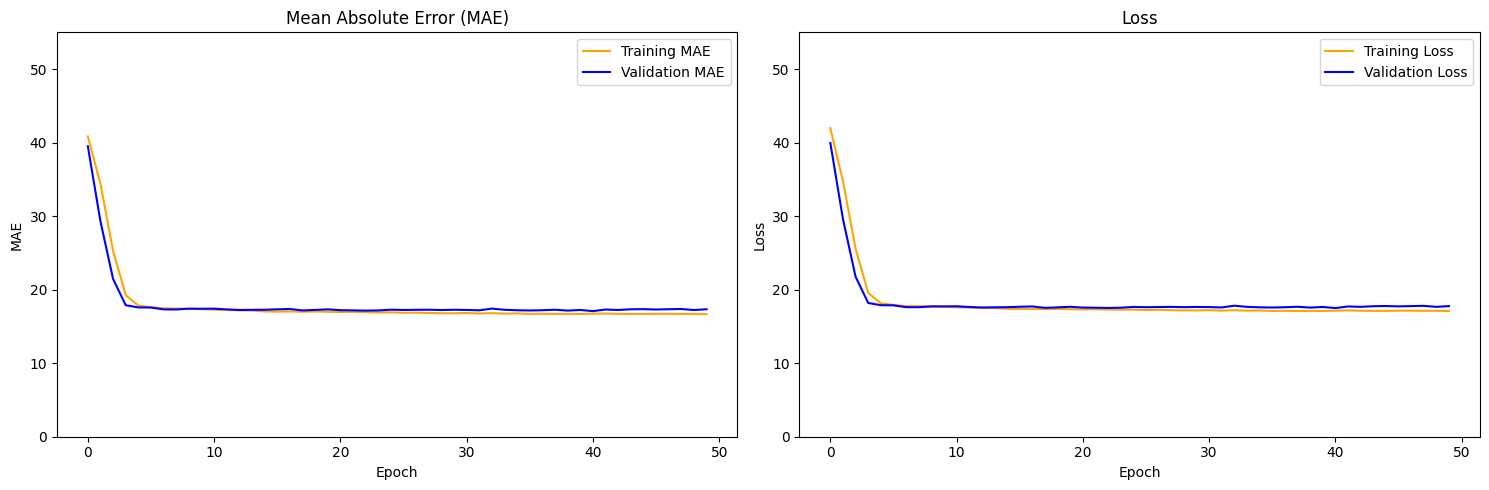

r2: 0.06684097138981782


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

In [ ]:
model13.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 30)                930       
                                                                 
 batch_normalization_16 (Ba  (None, 30)                120       
 tchNormalization)                                               
                                                                 
 dense_48 (Dense)            (None, 15)                465       
                                                                 
 batch_normalization_17 (Ba  (None, 15)                60        
 tchNormalization)                                               
                                                                 
 dense_49 (Dense)            (None, 7)                 112       
                                                                 
 batch_normalization_18 (Ba  (None, 7)                

<Figure size 1800x1400 with 0 Axes>

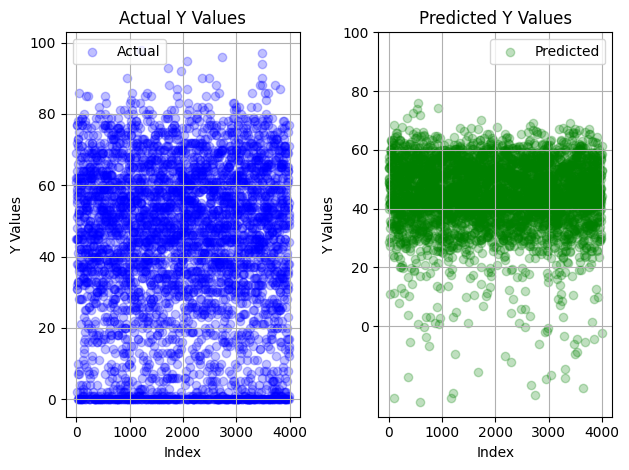

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

This is not better than previous models. Let's change the structure a little, adding a few layers.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model14 = keras.Sequential()

# Create a regularizer with a factor of 0.05
regularizer = keras.regularizers.l2(0.05)

# Declare the hidden layers
model14.add(layers.Dense(30, activation="relu", kernel_regularizer=regularizer))
model14.add(layers.BatchNormalization())
model14.add(layers.Dense(20, activation="relu", kernel_regularizer=regularizer)) # this was 15
model14.add(layers.BatchNormalization())
model14.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizer)) # this was 7
model14.add(layers.BatchNormalization())
model14.add(layers.Dense(5, activation="relu", kernel_regularizer=regularizer)) # this is new
model14.add(layers.BatchNormalization())


# Declare the output layer
# Single node output as this is regression
model14.add(Dense(1)) # Default activation is linear, no need to define any activation function here

# Compile the model
model14.compile(optimizer=tf.keras.optimizers.Adam(), # back to default learning rate
             loss=tf.keras.losses.MeanAbsoluteError(),
             metrics=[MeanAbsoluteError()])

In [ ]:
# fit model add
history = model14.fit(X_train_PCA, y_train, epochs=50, verbose=1, validation_data=(X_test_PCA, y_test))

# Keep a running tally of the training and validation history over ALL epochs
val_mae_list = []
val_mae_list = val_mae_list + history.history['val_mean_absolute_error']

val_loss_list = []
val_loss_list = val_loss_list + history.history['val_loss']

mae_list = []
mae_list = mae_list + history.history['mean_absolute_error']

loss_list = []
loss_list = loss_list + history.history['loss']

# Make predictions
y_pred = model14.predict(X_test_PCA)

Epoch 1/50
500/500 [==============================] - 6s 5ms/step - loss: 42.5819 - mean_absolute_error: 41.1261 - val_loss: 40.6958 - val_mean_absolute_error: 40.1107
Epoch 2/50
500/500 [==============================] - 4s 8ms/step - loss: 36.4767 - mean_absolute_error: 36.0347 - val_loss: 33.0774 - val_mean_absolute_error: 32.7080
Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 28.6889 - mean_absolute_error: 28.3386 - val_loss: 24.6948 - val_mean_absolute_error: 24.3526
Epoch 4/50
500/500 [==============================] - 2s 5ms/step - loss: 21.9198 - mean_absolute_error: 21.5810 - val_loss: 19.4904 - val_mean_absolute_error: 19.1639
Epoch 5/50
500/500 [==============================] - 2s 5ms/step - loss: 18.7528 - mean_absolute_error: 18.4311 - val_loss: 17.9635 - val_mean_absolute_error: 17.6435
Epoch 6/50
500/500 [==============================] - 3s 5ms/step - loss: 18.1072 - mean_absolute_error: 17.7848 - val_loss: 17.8230 - val_mean_absolute_error: 

In [ ]:
model14.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 30)                930       
                                                                 
 batch_normalization_19 (Ba  (None, 30)                120       
 tchNormalization)                                               
                                                                 
 dense_52 (Dense)            (None, 20)                620       
                                                                 
 batch_normalization_20 (Ba  (None, 20)                80        
 tchNormalization)                                               
                                                                 
 dense_53 (Dense)            (None, 10)                210       
                                                                 
 batch_normalization_21 (Ba  (None, 10)              

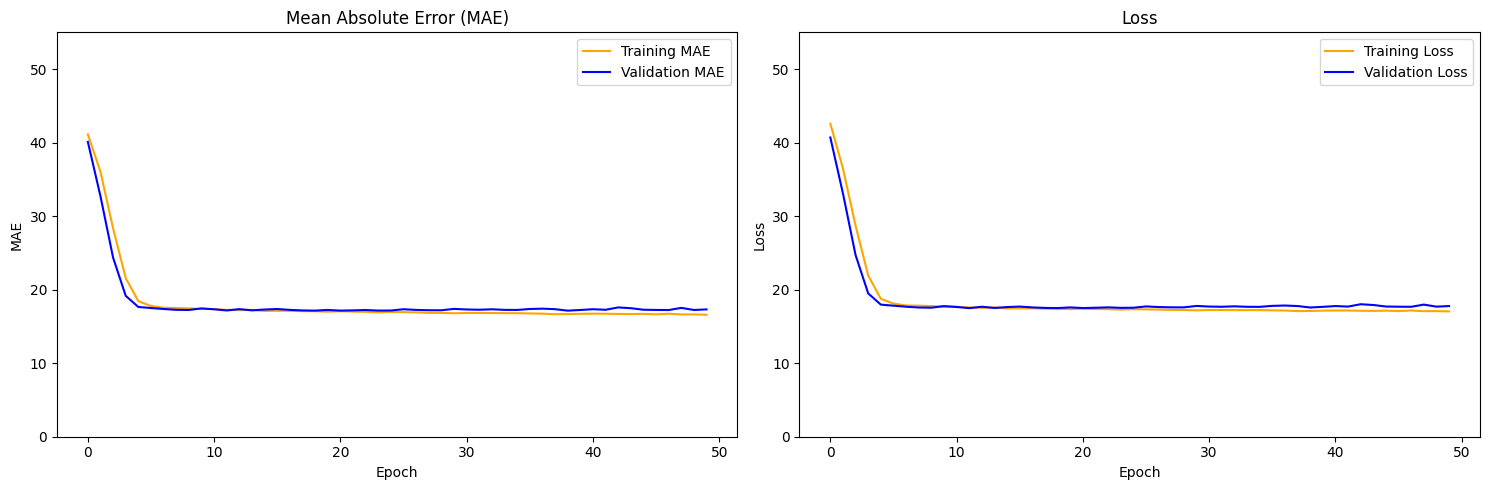

r2: 0.0699465114343778


In [ ]:
plt.figure(figsize=(15, 5))

# Plot for MAE
plt.subplot(1, 2, 1)
plt.plot(mae_list, c='orange', label='Training MAE')
plt.plot(val_mae_list, c='blue', label='Validation MAE')
plt.ylim(0, 55)
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(loss_list, c='orange', label='Training Loss')
plt.plot(val_loss_list, c='blue', label='Validation Loss')
plt.ylim(0, 55)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(f'r2: {r2_score(y_test,y_pred)}')

<Figure size 1800x1400 with 0 Axes>

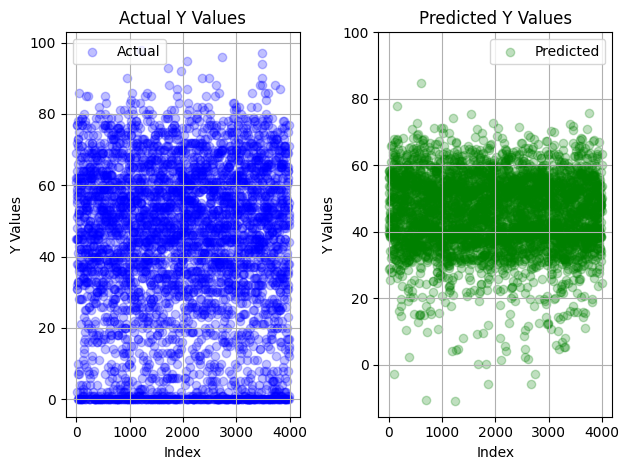

In [ ]:
# create a figure and two subplots
plt.figure(figsize=(18, 14))
plt.subplots(1,2)

# plot actual y values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.25)
plt.title('Actual Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.legend()
plt.grid(True)

# plot predicted y values
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Predicted', alpha=0.25)
plt.title('Predicted Y Values')
plt.xlabel('Index')
plt.ylabel('Y Values')
plt.yticks(np.arange(0, 101, 20))  # make the same as the other subplot
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

The r2 score is still very low (0.069) while the mean absolute error is the same (17.3). This does not look promising. I'll stop building neural network models here. Overall, the best one was model10 with 59 top features with the highest coefficients (according to the linear regression model).

In Parts 3-5, I've used the coefficients in the linear regression model to pick the best features but as I've shown in the previous notebook, we cannot keep all the features in a linear regression model since some of them have colinearity around 0.9. In the next part I'll do two linear regression model grid searches to find the best linear regression model. The search will be with 0.9 PCA, and so multi-colinearity will not be a problem. For the second grid search, I will first use VIF (variance inflation factor) to identify which features to include in the grid search, filtering multi-colinearity between the independent variables.

## Part 6: Linear Regression Models

The first model will have the PCA(0.9) features.

In [ ]:
# Define the pipeline with estimators
estimators = [
    ('scaling', None), # the data is already scaled
    ('dimred', PCA()),  # Dimensionality reduction using PCA
    ('model', Lasso())  # Lasso linear regression
]

# Create the pipeline
pipe = Pipeline(estimators)

# Caching for the pipeline
cachedir = mkdtemp()
cached_pipe = Pipeline(estimators, memory=cachedir)

# Define parameter distributions
param_grid = [
    {
        'dimred__n_components': [None],  # It is already 0.9, so None here
        'model': [Lasso()],  # Lasso regression
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Example values for Lasso alpha
    },
    {
        'dimred__n_components': [None],  # It is already 0.9, so None here
        'model': [Ridge()],  # Ridge regression
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Example values for Ridge alpha
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']  # Solvers appropriate for Ridge
    }
]

# Initialize GridSearchCV
grid = GridSearchCV(cached_pipe, param_grid, cv=5)

# Fit the grid search on the training data
fitted_grid = grid.fit(X_train_PCA, y_train)

# Get the best model from the grid search
best_model2 = grid.best_estimator_

# Use the best model to make predictions on the test set
y_pred_test = best_model2.predict(X_test_PCA)

# Calculate the mean absolute error (MAE) on the test set
test_mae = mean_absolute_error(y_test, y_pred_test)

# Get test R-squared
test_r2 = r2_score(y_test, y_pred_test)

# Use the best model to make predictions on the training set
y_pred_train = best_model2.predict(X_train_PCA)

# Calculate the training R-squared
train_r2 = r2_score(y_train, y_pred_train)

# Print the best parameters and test scores
print("Best Parameters:", fitted_grid.best_params_)
print("Best_Model2 Training R-squared:", train_r2)
print("Best_Model2 Test MAE:", test_mae)
print("Best_Model2 Test R-squared:", test_r2)

Best Parameters: {'dimred__n_components': None, 'model': Ridge(alpha=10, solver='svd'), 'model__alpha': 10, 'model__solver': 'svd'}
Best_Model2 Training R-squared: 0.0778173316019104
Best_Model2 Test MAE: 18.01133363631733
Best_Model2 Test R-squared: 0.08133666885174717


For the test data, the best model from the grid search has an MAE of 18 and an r2 of 0.08. This is really low compared to the best neural network model so far: Model10, which had an MAE of 16.2 and an r2 of 0.16.

Let's reload the scaled and splitted train and test data so that we don't need to scale them again.

In [ ]:
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/X_train.csv', index_col=0)
y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/y_train.csv',index_col=0)
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/X_test.csv', index_col=0)
y_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/y_test.csv', index_col=0)

Let's concatenate train and test data and do the VIF analysis.

In [ ]:
# Concatenate X_train and X_test along rows
X_comb = pd.concat([X_train, X_test], axis=0)
X_comb.shape

(19975, 69)

In [ ]:
X_comb.head()

Clear  Relatable  Memorable  Engaging  Symbolic  \
track_id                                                                     
0WEgOlUCB9nHPsoD8Ae4Zz  0.888889      0.625   0.777778     0.875  0.666667   
1KjQPDJQCUuqDj3AmfSBCa  0.444444      0.125   0.555556     0.500  0.222222   
0taOCiup4HNG9LmbduVlJj  0.444444      0.250   0.555556     0.375  0.222222   
7a9QBLlQOunA6KvPcVDIMt  0.666667      0.500   0.777778     0.625  0.444444   
69QIVIjPMnI1ABLBqh9P1b  0.777778      0.625   0.777778     0.750  0.444444   

                         Lyrical     Happy  Surprised  Fearful     Angry  \
track_id                                                                   
0WEgOlUCB9nHPsoD8Ae4Zz  0.777778  0.444444      0.625    0.250  0.222222   
1KjQPDJQCUuqDj3AmfSBCa  0.444444  0.111111      0.000    0.875  0.000000   
0taOCiup4HNG9LmbduVlJj  0.555556  0.111111      0.125    0.875  0.777778   
7a9QBLlQOunA6KvPcVDIMt  0.666667  0.333333      0.625    0.125  0.111111   
69QIVIjPMnI1ABLBqh9P1b  0.777778  0.555556      0.375    0.500  0.333333   

                        Disgusted    Sad  danceability  loudness  mode  \
track_id                                                                 
0WEgOlUCB9nHPsoD8Ae4Zz      0.375  0.750      0.368584  1.282079     0   
1KjQPDJQCUuqDj3AmfSBCa      0.000  0.125      0.595982  0.896323     1   
0taOCiup4HNG9LmbduVlJj      0.875  0.375      0.710785 -0.843307     1   
7a9QBLlQOunA6KvPcVDIMt      0.250  0.375      0.836627 -0.750427     0   
69QIVIjPMnI1ABLBqh9P1b      0.375  0.500      0.593774 -1.000931     1   

                         valence     tempo  duration_ms  \
track_id                                                  
0WEgOlUCB9nHPsoD8Ae4Zz  0.150496  0.780007     0.324599   
1KjQPDJQCUuqDj3AmfSBCa  0.599996  0.643504     0.333200   
0taOCiup4HNG9LmbduVlJj  0.516157  0.387052     0.259184   
7a9QBLlQOunA6KvPcVDIMt  0.172719  0.452517     0.493096   
69QIVIjPMnI1ABLBqh9P1b  0.830301  0.757543     0.473410   

                        album_release_quarter_1  album_release_quarter_3  \
track_id                                                                   
0WEgOlUCB9nHPsoD8Ae4Zz                        0                        0   
1KjQPDJQCUuqDj3AmfSBCa                        1                        0   
0taOCiup4HNG9LmbduVlJj                        0                        0   
7a9QBLlQOunA6KvPcVDIMt                        0                        1   
69QIVIjPMnI1ABLBqh9P1b                        1                        0   

                        album_release_quarter_4  album_decade_1960  \
track_id                                                             
0WEgOlUCB9nHPsoD8Ae4Zz                        1                  0   
1KjQPDJQCUuqDj3AmfSBCa                        0                  0   
0taOCiup4HNG9LmbduVlJj                        1                  0   
7a9QBLlQOunA6KvPcVDIMt                        0                  0   
69QIVIjPMnI1ABLBqh9P1b                        0                  0   

                        album_decade_1970  album_decade_1980  \
track_id                                                       
0WEgOlUCB9nHPsoD8Ae4Zz                  0                  0   
1KjQPDJQCUuqDj3AmfSBCa                  0                  0   
0taOCiup4HNG9LmbduVlJj                  0                  0   
7a9QBLlQOunA6KvPcVDIMt                  0                  0   
69QIVIjPMnI1ABLBqh9P1b                  0                  0   

                        album_decade_1990  album_decade_2000  \
track_id                                                       
0WEgOlUCB9nHPsoD8Ae4Zz                  0                  0   
1KjQPDJQCUuqDj3AmfSBCa                  0                  0   
0taOCiup4HNG9LmbduVlJj                  0                  0   
7a9QBLlQOunA6KvPcVDIMt                  0                  0   
69QIVIjPMnI1ABLBqh9P1b                  1                  0   

                        album_decade_2010  album_decade_2020  \
track_id                    

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each independent feature
vif_results = []

for i in range(X_comb.shape[1]):
    vif = variance_inflation_factor(X_comb.values, i)
    vif_results.append((X_comb.columns[i], vif))

# Display features with VIF above 5
hi_vif_cols = []
for feature, vif in vif_results:
    if vif >= 5:
        hi_vif_cols.append(feature)
        print(f"{feature}: {vif}")

Clear: 109.62681438208784
Relatable: 51.15493350155095
Memorable: 171.9001119442894
Engaging: 145.95350927956463
Symbolic: 71.90262353366282
Lyrical: 175.91053527101616
Happy: 14.43870209061297
Surprised: 15.062224373209796
Fearful: 11.351956339407334
Angry: 12.184778583522403
Disgusted: 19.753422547736108
Sad: 29.993091651953666
danceability: 27.63773097691359
valence: 8.616885129665334
tempo: 11.145934614783759
duration_ms: 15.883343178822868
album_decade_1970: 5.657747383722366
album_decade_1980: 8.665954712962488
album_decade_1990: 16.53012687913941
album_decade_2000: 25.760531909536105
album_decade_2010: 124.71096151763841
album_decade_2020: 5.155069150188396
key_1: 5.266339202018352
lang_English: 12.417729459536472


Let's drop these from the data.

In [ ]:
X_train_vif = X_train.drop(columns=['Clear', 'Relatable', 'Memorable', 'Engaging', 'Symbolic', 'Lyrical', 'Happy',
                                    'Surprised','Fearful', 'Angry', 'Disgusted', 'Sad', 'danceability', 'valence',
                                    'tempo', 'duration_ms', 'album_decade_1970', 'album_decade_1980','album_decade_1990',
                                    'album_decade_2000', 'album_decade_2010', 'album_decade_2020', 'key_1', 'lang_English'])

X_test_vif = X_test.drop(columns=['Clear', 'Relatable', 'Memorable', 'Engaging', 'Symbolic', 'Lyrical', 'Happy',
                                    'Surprised','Fearful', 'Angry', 'Disgusted', 'Sad', 'danceability', 'valence',
                                    'tempo', 'duration_ms', 'album_decade_1970', 'album_decade_1980','album_decade_1990',
                                    'album_decade_2000', 'album_decade_2010', 'album_decade_2020', 'key_1', 'lang_English'])

X_train_vif.shape, X_test_vif.shape

((15980, 45), (3995, 45))

In [ ]:
# Define the pipeline with estimators
estimators = [
    ('scaling', None), # the data is already scaled
    ('dimred', PCA()),  # Dimensionality reduction using PCA
    ('model', Lasso())  # Lasso linear regression
]

# Create the pipeline
pipe = Pipeline(estimators)

# Caching for the pipeline
cachedir = mkdtemp()
cached_pipe = Pipeline(estimators, memory=cachedir)

# Define parameter distributions
param_grid = [
    {
        'dimred__n_components': [None],  # we are not doing any reduction so none
        'model': [Lasso()],  # Lasso regression
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Example values for Lasso alpha
    },
    {
        'dimred__n_components': [None],  # we are not doing any reduction so none
        'model': [Ridge()],  # Ridge regression
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Example values for Ridge alpha
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']  # Solvers appropriate for Ridge
    }
]

# Initialize GridSearchCV
grid = GridSearchCV(cached_pipe, param_grid, cv=5)

# Fit the grid search on the training data
fitted_grid = grid.fit(X_train_vif, y_train)

# Get the best model from the grid search
best_model3 = grid.best_estimator_

# Use the best model to make predictions on the test set
y_pred_test = best_model3.predict(X_test_vif)

# Calculate the mean absolute error (MAE) on the test set
test_mae = mean_absolute_error(y_test, y_pred_test)

# Get test R-squared
test_r2 = r2_score(y_test, y_pred_test)

# Use the best model to make predictions on the training set
y_pred_train = best_model3.predict(X_train_vif)

# Calculate the training R-squared
train_r2 = r2_score(y_train, y_pred_train)

# Print the best parameters and test scores
print("Best Parameters:", fitted_grid.best_params_)
print("Best_Model3 Training R-squared:", train_r2)
print("Best_Model3 Test MAE:", test_mae)
print("Best_Model3 Test R-squared:", test_r2)

Best Parameters: {'dimred__n_components': None, 'model': Ridge(alpha=1, solver='lsqr'), 'model__alpha': 1, 'model__solver': 'lsqr'}
Best_Model3 Training R-squared: 0.13794086814157436
Best_Model3 Test MAE: 17.469339178653826
Best_Model3 Test R-squared: 0.11982351917072609


Scores of the best model from the grid search are as follows. MAE on the test data is 17.4, and r2 is ~0.12. This model is better than the previous linear regression on the PCA data, but not better than the best neural network model. Let's pickle that one: model10.

In [ ]:
model10.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 59)                3540      
                                                                 
 batch_normalization_29 (Ba  (None, 59)                236       
 tchNormalization)                                               
                                                                 
 dense_67 (Dense)            (None, 29)                1740      
                                                                 
 dense_68 (Dense)            (None, 14)                420       
                                                                 
 batch_normalization_30 (Ba  (None, 14)                56        
 tchNormalization)                                               
                                                                 
 dense_69 (Dense)            (None, 7)               

In [ ]:
import pickle

# Save the model to a file
pickle.dump(model10, open('/content/drive/My Drive/Colab Notebooks/datasets/neural_network_model10.pkl', 'wb'))

In [ ]:
# Load the model to double check
loaded_model10 = pickle.load(open('/content/drive/My Drive/Colab Notebooks/datasets/neural_network_model10.pkl', 'rb'))

In [ ]:
loaded_model10.summary() # Get the summary

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 59)                3540      
                                                                 
 batch_normalization_29 (Ba  (None, 59)                236       
 tchNormalization)                                               
                                                                 
 dense_67 (Dense)            (None, 29)                1740      
                                                                 
 dense_68 (Dense)            (None, 14)                420       
                                                                 
 batch_normalization_30 (Ba  (None, 14)                56        
 tchNormalization)                                               
                                                                 
 dense_69 (Dense)            (None, 7)               